<a href="https://colab.research.google.com/github/LilianaGarciaM/NLP/blob/main/KLM_Injury_Model_LG_Full_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

**Objective:**

*   Build a machine learning classifier that can predict whether a safety incident report involves an injury based on the text of the report. This is a critical task for enhancing safety processes at the airline by allowing quicker identification of incidents that require immediate attention.

**---Dataset---**

The dataset (safety_incident_reports.csv) contains 517 safety incident reports from airline employees.

*   It includes the following columns:

**Description:**
*   The text description of the safety incident, which can be in English or Dutch.
*   The description may or may not indicate that an injury occurred.

**Labels.** A binary label where:
*   1 indicates the incident resulted in an injury.
*   0 indicates no injury occurred.


# Import general packages

In [1]:
## packages to connect to google drive
!pip install -U -q PyDrive2
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

In [2]:
# Load basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from pandas import Series, DataFrame
from collections import Counter


# Data pre-processing

## Import data

In [3]:
## authorize the connection to google drive
auth.authenticate_user()
gauth=GoogleAuth()
gauth.credentials=GoogleCredentials.get_application_default()
drive=GoogleDrive(gauth)

In [4]:
# get the file from google drive
# https://drive.google.com/file/d/1sbCqXqj1xlPVOG-YZYFHyKJcuzvn4QL7/view?usp=drive_link
downloaded=drive.CreateFile({'id':'1sbCqXqj1xlPVOG-YZYFHyKJcuzvn4QL7'})
downloaded.GetContentFile('safety_incident_reports.csv')
df=pd.read_csv(open('safety_incident_reports.csv'),sep=',')

In [5]:
df

,Description,label
0,A power surge disrupted airport check-in syste...,0
1,Een stewardess liep een blauwe plek op aan haa...,1
2,Een stewardess verstuikte haar enkel tijdens e...,1
3,A ramp crew member suffered lacerations from h...,1
4,Een beveiligingsmedewerker werd gebeten door e...,1
...,...,...
512,A passenger experienced dizziness and nausea ...,1
513,A cleaner slipped on a wet cabin floor and hur...,1
514,A ground crew vehicle collided with a parked a...,0
515,Een passagier liep een whiplash op door onverw...,1


## Analyze data quality

In [6]:
# Check dataframe
df.info()
df.describe()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  517 non-null    object
 1   label        517 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.2+ KB


,0
Description,object
label,int64


In [7]:
# Check percentage of missing values per column
missing_percent = df.isnull().mean() * 100
print("Percentage of missing values per column:")
print(missing_percent)

Percentage of missing values per column:
Description    0.0
label          0.0
dtype: float64


In [8]:
# Count the number of descriptions per label
label_counts = df['label'].value_counts().sort_index()
print("\nNumber of descriptions per label:")
print(label_counts)


Number of descriptions per label:
label
0    245
1    272
Name: count, dtype: int64


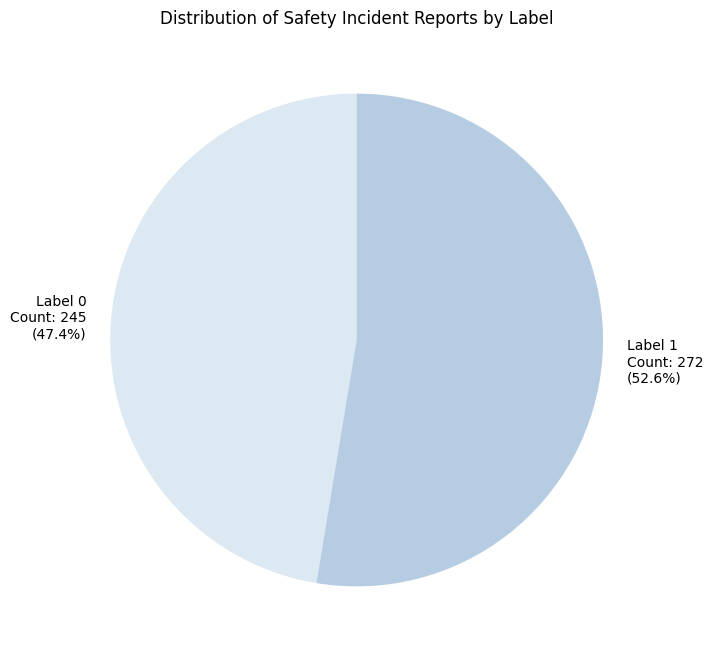

In [9]:
# Plot a pie chart for the distribution of reports per label

# Calculate percentages for labels
total = label_counts.sum()
label_percentages = label_counts / total * 100

# Labels for the pie chart
labels = [f"Label {label}\nCount: {count}\n({percentage:.1f}%)"
          for label, count, percentage in zip(label_counts.index, label_counts.values, label_percentages.values)]

plt.figure(figsize=(8,8))
plt.pie(label_counts, labels=labels, autopct='', startangle=90, colors=sns.color_palette('BuPu'))
plt.title("Distribution of Safety Incident Reports by Label")
plt.show()

In [10]:
# Identify repeated items for the 'Description' column
if 'Description' in df.columns:
    num_total = df.shape[0]
    num_unique = df['Description'].nunique()
    num_duplicates = num_total - num_unique
    print(f"\nTotal descriptions: {num_total}")
    print(f"Unique descriptions: {num_unique}")
    print(f"Number of repeated (duplicate) reports: {num_duplicates}")
else:
    print("Column 'Description' not found in the dataset.")


Total descriptions: 517
Unique descriptions: 517
Number of repeated (duplicate) reports: 0


In [11]:
# Calculate the length of the 'Description' column
df['Description_length'] = df['Description'].apply(len)

# Detecting outliers using the IQR method
Q1 = df['Description_length'].quantile(0.25)
Q3 = df['Description_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Description_length'] < lower_bound) | (df['Description_length'] > upper_bound)]

# Count outliers
outlier_count = outliers.shape[0]

print("Outliers:")
print(outliers)
print(f"Total number of outliers: {outlier_count}")

Outliers:
                                           Description  label  \
35   Een cateringwagen raakte een vleugel, wat insp...      0   
40   Een fout in de planning gaf twee vluchten deze...      0   
124  Een toilet aan boord werkte niet goed tijdens ...      0   
148  Een passagier had een onleesbaar ticket door g...      0   
205  Een medewerker op het platform werd geraakt do...      1   
283  Een defecte slurf vertraagde het uitstappen va...      0   
369  Een brugbestuurder struikelde over een kabel e...      1   
393  Een platformwerker liep bevriezingsverschijnse...      1   

     Description_length  
35                   61  
40                   56  
124                  56  
148                  57  
205                 111  
283                  59  
369                 114  
393                 113  
Total number of outliers: 8


Text(0.5, 1.0, 'Description Length Boxplot')

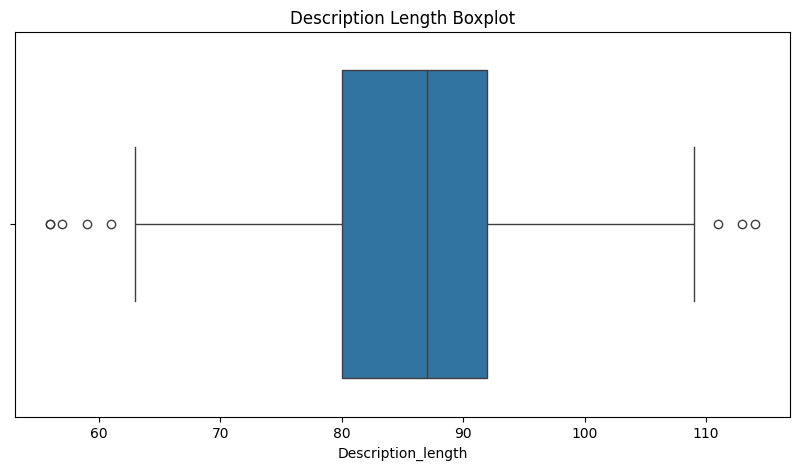

In [12]:
# Boxplot to visualize the outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Description_length'])
plt.title('Description Length Boxplot')

## Install language packages

In [13]:
# Install required libraries (if not already installed)
!pip install -q langdetect
!pip install -q googletrans==4.0.0-rc1
!pip install -q langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langsmith 0.3.5 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
openai 1.61.1 require

## Identify language (langdetect)


In [14]:
from langdetect import detect, DetectorFactory, LangDetectException

In [15]:
# Set a seed for langdetect to make its results deterministic
DetectorFactory.seed = 0

In [16]:
# Create a function for safe language detection
def safe_detect(text):
    if pd.isnull(text) or not isinstance(text, str) or text.strip() == "":
        return None
    try:
        return detect(text)
    except LangDetectException:
        return None

# Apply the language detection function to the 'Description' column
df['language'] = df['Description'].apply(safe_detect)


In [17]:
# Calculate the language distribution
lang_counts = df['language'].value_counts(dropna=False)
lang_percentages = lang_counts / lang_counts.sum() * 100

# Create a summary DataFrame
lang_summary = pd.DataFrame({
    'Count': lang_counts,
    'Percentage': lang_percentages.round(1)
}).reset_index().rename(columns={'index': 'language'})

print("\nLanguage Distribution:")
print(lang_summary)


Language Distribution:
  language  Count  Percentage
0       en    353        68.3
1       nl    158        30.6
2       af      4         0.8
3       da      2         0.4


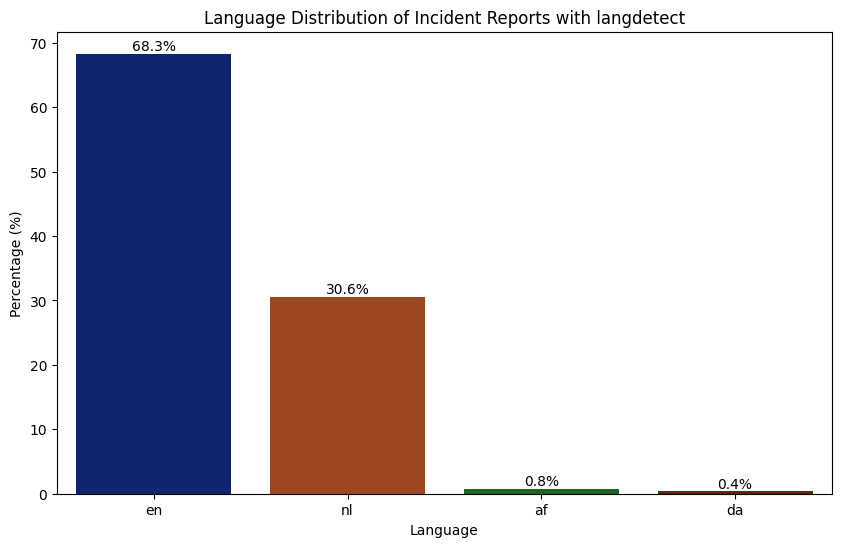

In [18]:
plt.figure(figsize=(10, 6))
# Create the bar chart
bar_plot = sns.barplot(data=lang_summary,
                       x='language',
                       y='Percentage',
                       hue='language',
                       palette='dark',
                       dodge=False)

if bar_plot.get_legend() is not None:
    bar_plot.get_legend().remove()

plt.title("Language Distribution of Incident Reports with langdetect")
plt.ylabel("Percentage (%)")
plt.xlabel("Language")

# Labels for the chart
for index, row in lang_summary.iterrows():
    bar_plot.text(index, row.Percentage + 0.5, f"{row.Percentage}%",
                  color='black', ha="center")

plt.show()

In [19]:
df

,Description,label,Description_length,language
0,A power surge disrupted airport check-in syste...,0,80,en
1,Een stewardess liep een blauwe plek op aan haa...,1,107,nl
2,Een stewardess verstuikte haar enkel tijdens e...,1,88,nl
3,A ramp crew member suffered lacerations from h...,1,94,en
4,Een beveiligingsmedewerker werd gebeten door e...,1,96,nl
...,...,...,...,...
512,A passenger experienced dizziness and nausea ...,1,95,en
513,A cleaner slipped on a wet cabin floor and hur...,1,86,en
514,A ground crew vehicle collided with a parked a...,0,92,en
515,Een passagier liep een whiplash op door onverw...,1,88,nl


## Identify language (langid)

In [20]:
import langid  # Another language detection package

In [21]:
# Create a function for safe language detection using langid
def safe_detect_langid(text):
    if pd.isnull(text) or not isinstance(text, str) or text.strip() == "":
        return None
    try:
        # langid.classify returns a tuple: (language_code, confidence)
        lang, confidence = langid.classify(text)
        return lang
    except Exception as e:
        print("Language detection error:", e)
        return None

#  Apply the language detection function to the 'Description' column and store detected language in a new column 'language2'
df['language2'] = df['Description'].apply(safe_detect_langid)


In [22]:
# Calculate the language distribution based on 'language2'
lang_counts = df['language2'].value_counts(dropna=False)
lang_percentages = lang_counts / lang_counts.sum() * 100

# Create a summary DataFrame
lang_summary = pd.DataFrame({
    'Count': lang_counts,
    'Percentage': lang_percentages.round(1)
}).reset_index().rename(columns={'index': 'language2'})

print("\nLanguage Distribution (using language2):")
print(lang_summary)


Language Distribution (using language2):
  language2  Count  Percentage
0        en    355        68.7
1        nl    162        31.3


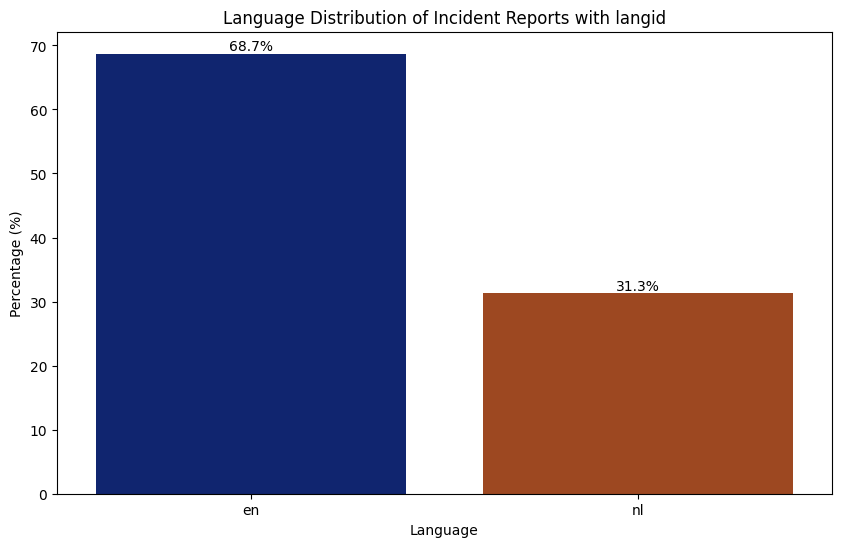

In [23]:
# Create a summary DataFrame for plotting:
lang_counts = df['language2'].value_counts(dropna=False)
lang_percentages = lang_counts / lang_counts.sum() * 100

# Create a summary DataFrame
lang_summary = pd.DataFrame({
    'Count': lang_counts,
    'Percentage': lang_percentages.round(1)
}).reset_index().rename(columns={'index': 'language2'})

# Plot the language distribution in a bar chart
plt.figure(figsize=(10,6))
bar_plot = sns.barplot(
    data=lang_summary,
    x='language2',
    y='Percentage',
    hue='language2',
    palette='dark',
    dodge=False
)
plt.title("Language Distribution of Incident Reports with langid")
plt.ylabel("Percentage (%)")
plt.xlabel("Language")
plt.legend([], [], frameon=False)

# Labels for the chart
for index, row in lang_summary.iterrows():
    bar_plot.text(index, row.Percentage + 0.5, f"{row.Percentage}%", color='black', ha="center")

plt.show()


In [24]:
# Validate some examples where language with langdetect identified as afrikaans
print(df.loc[df['language'].isin(['af']), :])


                                           Description  label  \
382  Een oudere passagier viel van de vliegtuigtrap...      1   
436  Een landingsbaan was afgesloten voor herasfalt...      0   
490  Een shuttlebus naar het vliegtuig brak af, waa...      0   
502  Een passagier stapte per ongeluk in het verkee...      0   

     Description_length language language2  
382                  65       af        nl  
436                  82       af        nl  
490                  81       af        nl  
502                  80       af        nl  


In [25]:
# Validate some examples where language with langdetect identified as danish
print(df.loc[df['language'].isin(['da']), :])

                                           Description  label  \
406  The airport's baggage handling system broke do...      0   
438  A luggage conveyor belt jammed, delaying bagga...      0   

     Description_length language language2  
406                  76       da        en  
438                  79       da        en  


In [26]:
# Validate some examples where language with langid identified as dutch
print(df.loc[df['language2'].isin(['nl']), :])

                                           Description  label  \
1    Een stewardess liep een blauwe plek op aan haa...      1   
2    Een stewardess verstuikte haar enkel tijdens e...      1   
4    Een beveiligingsmedewerker werd gebeten door e...      1   
7    Een passagier struikelde over een kinderspeelg...      1   
10   Een reiziger viel op een loopband en ontwricht...      1   
..                                                 ...    ...   
502  Een passagier stapte per ongeluk in het verkee...      0   
504  Een reiziger viel op een loopband en liep een ...      1   
507  Een passagier klaagde over pijn op de borst en...      1   
509  Een passagier raakte gewond tijdens een snelle...      1   
515  Een passagier liep een whiplash op door onverw...      1   

     Description_length language language2  
1                   107       nl        nl  
2                    88       nl        nl  
4                    96       nl        nl  
7                   101       nl       

In [27]:
df

,Description,label,Description_length,language,language2
0,A power surge disrupted airport check-in syste...,0,80,en,en
1,Een stewardess liep een blauwe plek op aan haa...,1,107,nl,nl
2,Een stewardess verstuikte haar enkel tijdens e...,1,88,nl,nl
3,A ramp crew member suffered lacerations from h...,1,94,en,en
4,Een beveiligingsmedewerker werd gebeten door e...,1,96,nl,nl
...,...,...,...,...,...
512,A passenger experienced dizziness and nausea ...,1,95,en,en
513,A cleaner slipped on a wet cabin floor and hur...,1,86,en,en
514,A ground crew vehicle collided with a parked a...,0,92,en,en
515,Een passagier liep een whiplash op door onverw...,1,88,nl,nl


## Translate non-English descriptions to English

In [28]:
from googletrans import Translator

In [29]:
# Initialize translator
translator = Translator()

# Create function to translate into english
def translate_to_english(text, src_lang):
    """
    Translate text to English if it is not already in English.
    If the text is already in English or is empty, return it unchanged.
    """
    if pd.isnull(text) or text.strip() == "":
        return text
    if src_lang == 'en':
        return text
    try:
        # Translate to English using googletrans
        translation = translator.translate(text, src='auto', dest='en')
        return translation.text
    except Exception as e:
        print("Translation error:", e)
        return text

# Apply the translation function based on 'language2' and create a new column 'Description_English'
df['Description_English'] = df.apply(lambda row: translate_to_english(row['Description'], row['language2']), axis=1)


In [30]:
# Inspect a few examples
print("\nSample translations:")
print(df[['Description', 'language2', 'Description_English']].head())


Sample translations:
                                         Description language2  \
0  A power surge disrupted airport check-in syste...        en   
1  Een stewardess liep een blauwe plek op aan haa...        nl   
2  Een stewardess verstuikte haar enkel tijdens e...        nl   
3  A ramp crew member suffered lacerations from h...        en   
4  Een beveiligingsmedewerker werd gebeten door e...        nl   

                                 Description_English  
0  A power surge disrupted airport check-in syste...  
1  A stewardess rose a bruise on her arm due to a...  
2  A stewardess sprained her ankle during a safet...  
3  A ramp crew member suffered lacerations from h...  
4  A security employee was bitten by an assistanc...  


In [31]:
# Save the DataFrame to an Excel file named "safety_incident_reports_translated.xlsx"
output_excel_file = "safety_incident_reports_translated.xlsx"
df.to_excel(output_excel_file, index=False)
print(f"\nUpdated dataset with translations saved to '{output_excel_file}'.")


Updated dataset with translations saved to 'safety_incident_reports_translated.xlsx'.


In [32]:
#google colab for downloading files
#If download is required, then:

#files.download(output_excel_file)

In [33]:
df.dtypes

,0
Description,object
label,int64
Description_length,int64
language,object
language2,object
Description_English,object


# Text pre-processing

## Install required text pre-processing packages

In [34]:
# If not installed, install contractions:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.9 MB/s eta 0:00:00


## Import libraries and packages for text pre-processing

In [35]:
import re
import string
import nltk
import contractions

#Download necessary NLTK data
nltk.download('stopwords') # English stopwords
nltk.download('punkt') # Tokenizer models
nltk.download('punkt_tab') # Tokenizer models
nltk.download('wordnet') # Lemmatizer data
nltk.download('averaged_perceptron_tagger') # POS Tagger
nltk.download('averaged_perceptron_tagger_eng')# POS Tagger

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


## Pre-process text

In [36]:
# Initialize stop words and lemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Create function for POS
def get_wordnet_pos(treebank_tag):
    """
    Map NLTK's part-of-speech tags to WordNet's part-of-speech tags
    for more accurate lemmatization.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Create function to pre-process text

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Expand contractions
    # For example, "isn't" -> "is not", "doesn't" -> "does not"
    text = contractions.fix(text)

    # Replace specific words/phrases: "check-in" -> "checkin"
    text = text.replace("check-in", "checkin")

    # Remove URLs, added just to make the cleaning function more robust
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # Remove HTML tags, added just to make the cleaning function more robust
    text = re.sub(r"<.*?>", '', text)

    # Remove digits
    text = re.sub(r"\d+", '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Handle extra whitespace / line breaks
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and short tokens
    tokens = [token for token in tokens if token not in stop_words and len(token) > 1]

    # POS tagging for better lemmatization
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize with correct POS
    lemmed_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for (word, pos) in pos_tags]

    # Rejoin tokens
    return " ".join(lemmed_tokens)

# Apply the preprocessing function to your "Description_English" column
df["Processed_English"] = df["Description_English"].astype(str).apply(preprocess_text)

# Preview the results
df[["Description_English", "Processed_English"]].head()


,Description_English,Processed_English
0,A power surge disrupted airport check-in syste...,power surge disrupt airport checkin system del...
1,A stewardess rose a bruise on her arm due to a...,stewardess rise bruise arm due defective cart ...
2,A stewardess sprained her ankle during a safet...,stewardess sprain ankle safety demonstration a...
3,A ramp crew member suffered lacerations from h...,ramp crew member suffer laceration handle brok...
4,A security employee was bitten by an assistanc...,security employee bite assistance dog become r...


In [37]:
df.head()

,Description,label,Description_length,language,language2,Description_English,Processed_English
0,A power surge disrupted airport check-in syste...,0,80,en,en,A power surge disrupted airport check-in syste...,power surge disrupt airport checkin system del...
1,Een stewardess liep een blauwe plek op aan haa...,1,107,nl,nl,A stewardess rose a bruise on her arm due to a...,stewardess rise bruise arm due defective cart ...
2,Een stewardess verstuikte haar enkel tijdens e...,1,88,nl,nl,A stewardess sprained her ankle during a safet...,stewardess sprain ankle safety demonstration a...
3,A ramp crew member suffered lacerations from h...,1,94,en,en,A ramp crew member suffered lacerations from h...,ramp crew member suffer laceration handle brok...
4,Een beveiligingsmedewerker werd gebeten door e...,1,96,nl,nl,A security employee was bitten by an assistanc...,security employee bite assistance dog become r...


In [38]:
# Save the DataFrame to an Excel file named "safety_incident_reports_translated_preprocessed.xlsx"
output_excel_file = "safety_incident_reports_translated_preprocessed.xlsx"
df.to_excel(output_excel_file, index=False)
print(f"\nUpdated dataset with translations saved to '{output_excel_file}'.")


Updated dataset with translations saved to 'safety_incident_reports_translated_preprocessed.xlsx'.


In [39]:
#google colab for downloading files
#If download is required, then:

#files.download(output_excel_file)

In [40]:
df.dtypes

,0
Description,object
label,int64
Description_length,int64
language,object
language2,object
Description_English,object
Processed_English,object


## Visual validation of top words

In [41]:
# Dictionary to store top 30 words for each label
top_30_words_by_label = {}

# Iterate over each unique label
for lbl in df["label"].unique():
    # Subset rows for the current label
    subset = df[df["label"] == lbl]

    # Combine all text from 'Processed_English' into a single string
    # Drop any NaN rows, just in case
    combined_text = " ".join(subset["Processed_English"].dropna())

    # Split into individual tokens
    tokens = combined_text.split()

    # Get word frequency using Counter
    word_counts = Counter(tokens)

    # Retrieve the top 30 words (word, frequency) in descending order
    top_30 = word_counts.most_common(30)

    # Store in the dictionary
    top_30_words_by_label[lbl] = top_30

# Print results
for lbl, word_freqs in top_30_words_by_label.items():
    print(f"\nLabel = {lbl}")
    print("Top 30 words (descending frequency):")
    for word, freq in word_freqs:
        print(f"{word}: {freq}")



Label = 0
Top 30 words (descending frequency):
delay: 93
flight: 79
passenger: 72
cause: 62
due: 32
require: 27
board: 27
aircraft: 26
airport: 25
gate: 24
system: 23
terminal: 21
plane: 18
luggage: 18
departure: 17
runway: 15
crew: 15
lead: 15
malfunction: 15
miss: 14
check: 14
ground: 13
arrive: 13
delayed: 12
inspection: 12
wrong: 12
error: 11
baggage: 11
fuel: 11
power: 10

Label = 1
Top 30 words (descending frequency):
passenger: 78
flight: 54
suffer: 38
injure: 37
fell: 35
sustain: 34
injury: 33
burn: 30
due: 29
traveler: 28
turbulence: 26
airport: 26
luggage: 25
break: 24
pilot: 24
terminal: 23
heavy: 23
worker: 22
child: 22
hot: 20
cockpit: 19
fall: 19
member: 18
slip: 17
hit: 17
employee: 16
cabin: 16
head: 16
back: 16
spill: 15


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Description          517 non-null    object
 1   label                517 non-null    int64 
 2   Description_length   517 non-null    int64 
 3   language             517 non-null    object
 4   language2            517 non-null    object
 5   Description_English  517 non-null    object
 6   Processed_English    517 non-null    object
dtypes: int64(2), object(5)
memory usage: 28.4+ KB


# Modeling

## Import main packages

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report, confusion_matrix, roc_curve, auc, recall_score

## Model 1: logistic regression w/grid search

### Split data into training and test set, vectorize

In [44]:

# Define X (text) and y (labels)
X = df['Processed_English']
y = df['label']

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize the vectorizer (using TF-IDF)
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), #consider both unigrams and bigrams (single words and pairs of consecutive words)
    analyzer="word", #feature should be made up of words
    preprocessor=None, #no custom pre-processing function is applied to the text before tokenization
    stop_words='english',  #remove common english stop words
    max_df=0.8, #ignore terms that are more in 80% of the documents
    min_df=5, #ignore terms that appear in fewer than 5 documnts
)

# Fit the vectorizer on the training data and transform both training and test data
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Print the shape of X_train and X_test
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (361, 177)
X_test shape: (156, 177)


### Build model

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report, confusion_matrix, roc_curve, auc, recall_score

In [46]:

# Set up Logistic Regression with Grid Search using F1 score for evaluation

# Initialize logistic regression model
log_reg = LogisticRegression(solver='liblinear', max_iter=1000) # Using 'liblinear' to support both 'l1' and 'l2' penalties

# Define a grid of hyperparameters to search over
param_grid_lg = {
    'C': [0.01, 0.1, 1, 10, 100],   # Regularization strength
    'penalty': ['l1', 'l2']          # Regularization type
}

# Set up grid search with 5-fold cross-validation, using the weighted F1 score
grid_search_lg = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lg,
    cv=5,
    scoring='f1',  # Optimize for F1 score
    n_jobs=-1   # Use all available cores
)

# Fit grid search on the training data
grid_search_lg.fit(X_train, y_train)

# Print best parameters and best cross-validation score (F1)
print("Best Parameters:", grid_search_lg.best_params_)
print("Best Cross-Validation Score (F1):", grid_search_lg.best_score_)


Best Parameters: {'C': 10, 'penalty': 'l2'}
Best Cross-Validation Score (F1): 0.9563425450442994


In [47]:
# Evaluate the Best Model on the Test Set

# Predict on the test set using the best found model
y_pred_lg = grid_search_lg.predict(X_test)

# Calculate metrics
logreg_accuracy = accuracy_score(y_test, y_pred_lg)
logreg_f1 = f1_score(y_test, y_pred_lg)
logreg_precision = precision_score(y_test, y_pred_lg)
logreg_recall = recall_score(y_test, y_pred_lg)

# Print evaluation results
print(f"The accuracy of the logistic regression model is {logreg_accuracy:.4f}.")
print(f"The F1 score of the logistic regression model is {logreg_f1:.4f}.")
print(f"The precision of the logistic regression model is {logreg_precision:.4f}.")
print(f"The recall of the logistic regression model is {logreg_recall:.4f}.")

# Print the full classification report
print("Classification Report:\n", classification_report(y_test, y_pred_lg))

The accuracy of the logistic regression model is 0.9423.
The F1 score of the logistic regression model is 0.9474.
The precision of the logistic regression model is 0.9101.
The recall of the logistic regression model is 0.9878.
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94        74
           1       0.91      0.99      0.95        82

    accuracy                           0.94       156
   macro avg       0.95      0.94      0.94       156
weighted avg       0.95      0.94      0.94       156



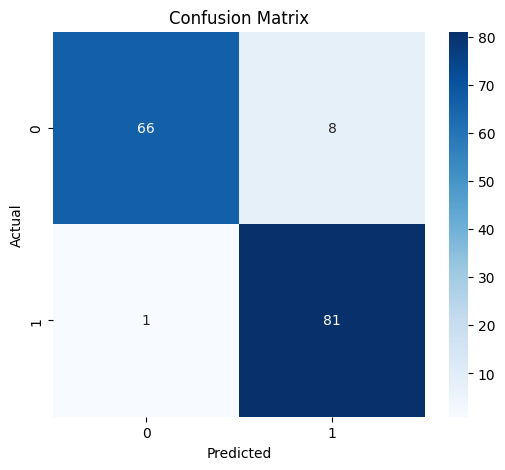

In [48]:
# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [49]:
# Confusion Matrix as a table
cm = confusion_matrix(y_test, y_pred_lg)
cm_table = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix (Table Format):")
print(cm_table)

Confusion Matrix (Table Format):
          Predicted 0  Predicted 1
Actual 0           66            8
Actual 1            1           81


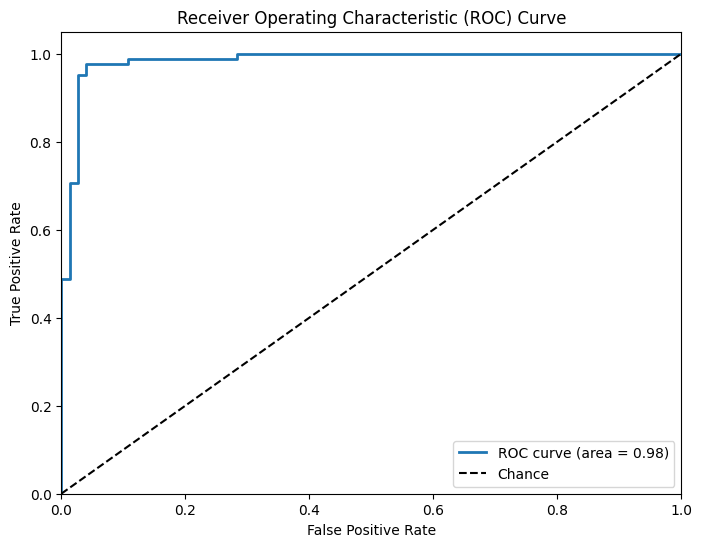

In [50]:
# Plot the ROC Curve
y_proba = grid_search_lg.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:0.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

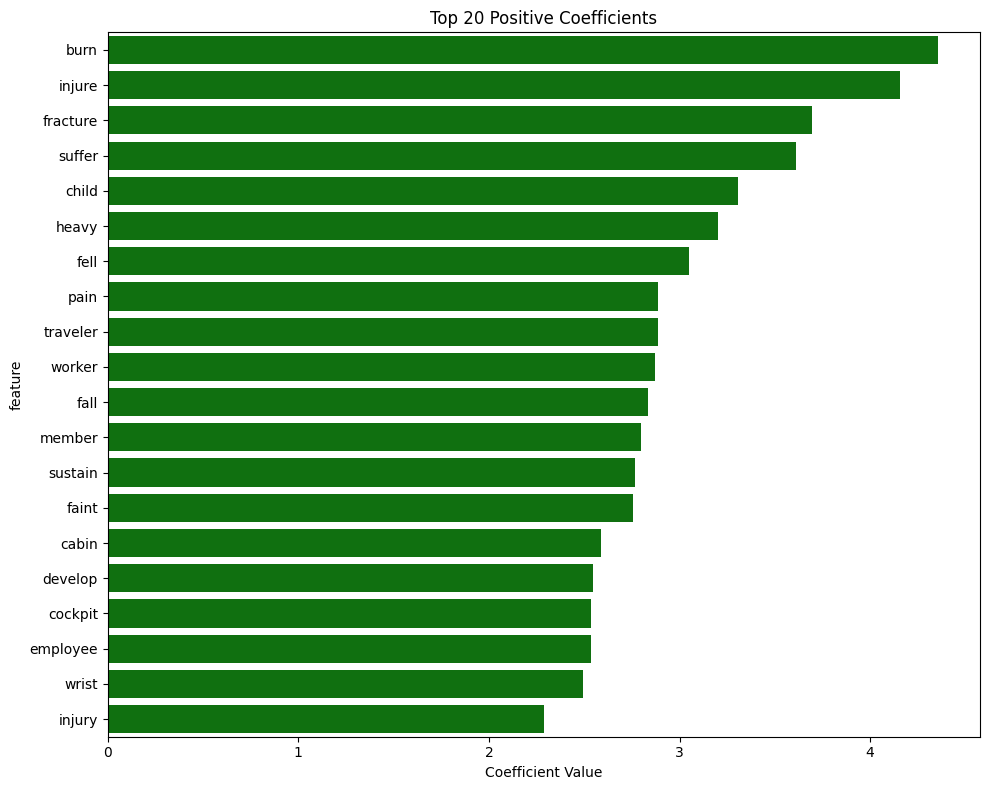

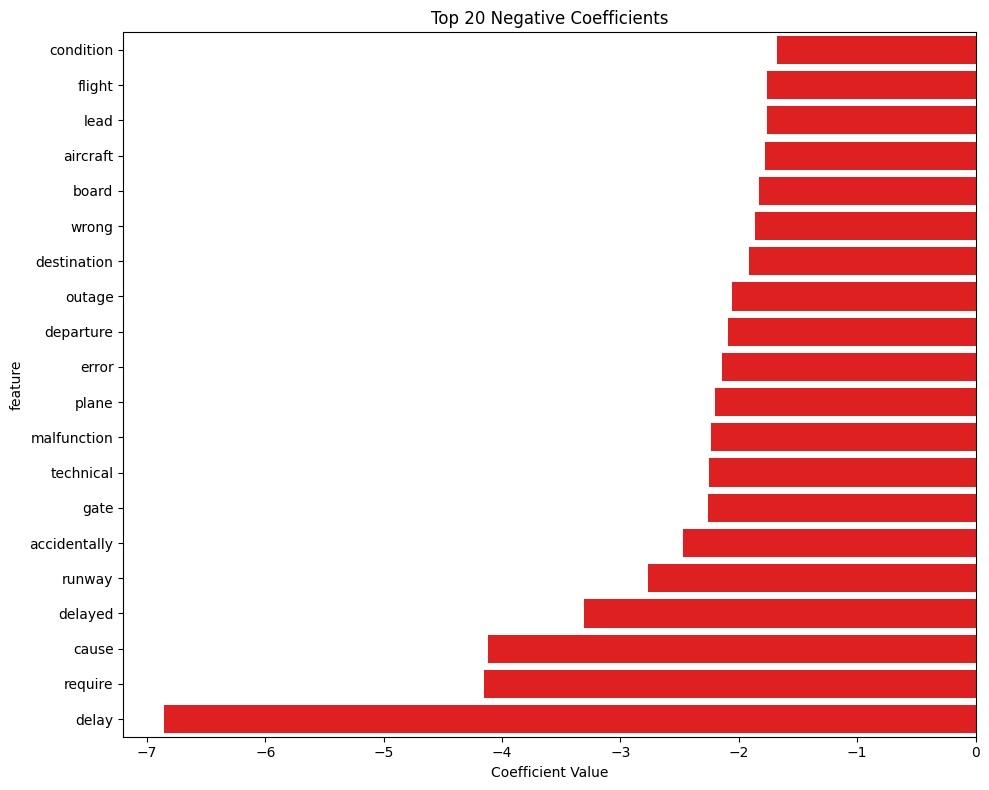

In [51]:
# Extract and Plot Logistic Regression Coefficients

# Get the best model from grid search.
best_model = grid_search_lg.best_estimator_

# Extract feature names and coefficients.
feature_names = vectorizer.get_feature_names_out()
coefficients = best_model.coef_[0]

# Create a DataFrame for the coefficients.
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort features by the coefficient values.
coef_df = coef_df.sort_values(by='coefficient', ascending=False)

# Plot the top 20 positive coefficients.
top_positive = coef_df.head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x='coefficient', y='feature', data=top_positive, color='green')
plt.xlabel('Coefficient Value')
plt.title('Top 20 Positive Coefficients')
plt.tight_layout()
plt.show()

# Plot the top 20 negative coefficients.
top_negative = coef_df.tail(20)
plt.figure(figsize=(10, 8))
sns.barplot(x='coefficient', y='feature', data=top_negative, color='red')
plt.xlabel('Coefficient Value')
plt.title('Top 20 Negative Coefficients')
plt.tight_layout()
plt.show()

### Test the model with new reports in English

In [52]:
# Define the new reports
new_reports = [
    "A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.",
    "A miscommunication between air traffic control and the ground operations team led to a temporary taxiway hold, impacting the departure schedule of a domestic flight.",
    "A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.",
    "A passenger twisted their ankle when slipping on a wet floor near the boarding gate."
]

# Preprocess the new reports
preprocessed_reports = [preprocess_text(report) for report in new_reports]

# Transform the new reports using the trained vectorizer
new_reports_transformed = vectorizer.transform(preprocessed_reports)

# Predict the labels using the trained model
predicted_labels = grid_search_lg.predict(new_reports_transformed)

# Display the predictions
for report, label in zip(new_reports, predicted_labels):
    print(f"Report: {report}\nPredicted Label: {label}\n")

Report: A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.
Predicted Label: 0

Report: A miscommunication between air traffic control and the ground operations team led to a temporary taxiway hold, impacting the departure schedule of a domestic flight.
Predicted Label: 0

Report: A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.
Predicted Label: 1

Report: A passenger twisted their ankle when slipping on a wet floor near the boarding gate.
Predicted Label: 1



### Text the model with new reports in English and Dutch

In [53]:
# Define the new reports
new_reports_2 = [
    "A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.",
    "Een miscommunicatie tussen de luchtverkeersleiding en het grondoperatieteam leidde tot een tijdelijke taxibaanstop, met gevolgen voor het vertrekschema van een binnenlandse vlucht.",
    "A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.",
    "Een passagier verzwikte zijn enkel toen hij uitgleed over een natte vloer bij de instapgate.."
]

# Detect the language and translate new reports to English if needed
translated_reports = []
for report in new_reports_2:
    detected_lang = safe_detect_langid(report)
    translated_report = translate_to_english(report, detected_lang)
    translated_reports.append(translated_report)

# Preprocess the translated reports
preprocessed_reports = [preprocess_text(report) for report in translated_reports]

# Transform the preprocessed reports using the trained vectorizer
new_reports_transformed = vectorizer.transform(preprocessed_reports)

# Predict the labels using the trained model
predicted_labels = grid_search_lg.predict(new_reports_transformed)

# Display the predictions
for report, label in zip(new_reports_2, predicted_labels):
    print(f"Report: {report}\nPredicted Label: {label}\n")

Report: A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.
Predicted Label: 0

Report: Een miscommunicatie tussen de luchtverkeersleiding en het grondoperatieteam leidde tot een tijdelijke taxibaanstop, met gevolgen voor het vertrekschema van een binnenlandse vlucht.
Predicted Label: 0

Report: A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.
Predicted Label: 1

Report: Een passagier verzwikte zijn enkel toen hij uitgleed over een natte vloer bij de instapgate..
Predicted Label: 1



## Model 2: Multinomial Naive Bayes

### Split data into training and test set, vectorize

In [54]:

# Define X (text) and y (labels)
X = df['Processed_English']
y = df['label']

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize the vectorizer (using TF-IDF)
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), #consider both unigrams and bigrams (single words and pairs of consecutive words)
    analyzer="word", #feature should be made up of words
    preprocessor=None, #no custom pre-processing function is applied to the text before tokenization
    stop_words='english',  #remove common english stop words
    max_df=0.8, #ignore terms that are more in 80% of the documents
    min_df=5, #ignore terms that appear in fewer than 5 documnts
)

# Fit the vectorizer on the training data and transform both training and test data
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Print the shape of X_train and X_test
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (361, 177)
X_test shape: (156, 177)


### Build model

In [55]:
from sklearn.naive_bayes import MultinomialNB


In [56]:
# Set up Naive Bayes with Grid Search using F1 score for evaluation

# Initialize Naive Bayes model
nb_model = MultinomialNB()

# Define a grid of hyperparameters to search over
param_grid_nb = {
    'alpha': [0.01, 0.1, 1, 10, 100]  # Smoothing parameter
}

# Set up grid search with 5-fold cross-validation, using the weighted F1 score
grid_search_nb = GridSearchCV(
    estimator=nb_model,
    param_grid=param_grid_nb,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit grid search on the training data
grid_search_nb.fit(X_train, y_train)

# Print best parameters and best cross-validation score (F1)
print("Best Parameters (Naive Bayes):", grid_search_nb.best_params_)
print("Best Cross-Validation Score (F1) (Naive Bayes):", grid_search_nb.best_score_)

Best Parameters (Naive Bayes): {'alpha': 1}
Best Cross-Validation Score (F1) (Naive Bayes): 0.9587601521285732


In [57]:
# Evaluate the Best Model on the Test Set

# Predict on the test set using the best found model
y_pred_nb = grid_search_nb.predict(X_test)

# Calculate metrics
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_f1 = f1_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb)
nb_recall = recall_score(y_test, y_pred_nb)

# Print evaluation results
print(f"The accuracy of the Naive Bayes model is {nb_accuracy:.4f}.")
print(f"The F1 score of the Naive Bayes model is {nb_f1:.4f}.")
print(f"The precision of the Naive Bayes model is {nb_precision:.4f}.")
print(f"The recall of the Naive Bayes model is {nb_recall:.4f}.")

# Print the full classification report
print("Classification Report (Naive Bayes):\n", classification_report(y_test, y_pred_nb))

The accuracy of the Naive Bayes model is 0.9359.
The F1 score of the Naive Bayes model is 0.9405.
The precision of the Naive Bayes model is 0.9186.
The recall of the Naive Bayes model is 0.9634.
Classification Report (Naive Bayes):
               precision    recall  f1-score   support

           0       0.96      0.91      0.93        74
           1       0.92      0.96      0.94        82

    accuracy                           0.94       156
   macro avg       0.94      0.93      0.94       156
weighted avg       0.94      0.94      0.94       156



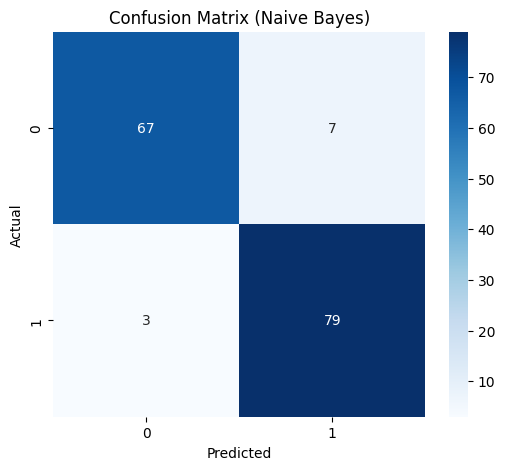

In [58]:
# Plot the Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Naive Bayes)")
plt.show()

In [59]:
# Confusion Matrix as a table
cm_table_nb = pd.DataFrame(cm_nb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix (Table Format) (Naive Bayes):")
print(cm_table_nb)

Confusion Matrix (Table Format) (Naive Bayes):
          Predicted 0  Predicted 1
Actual 0           67            7
Actual 1            3           79


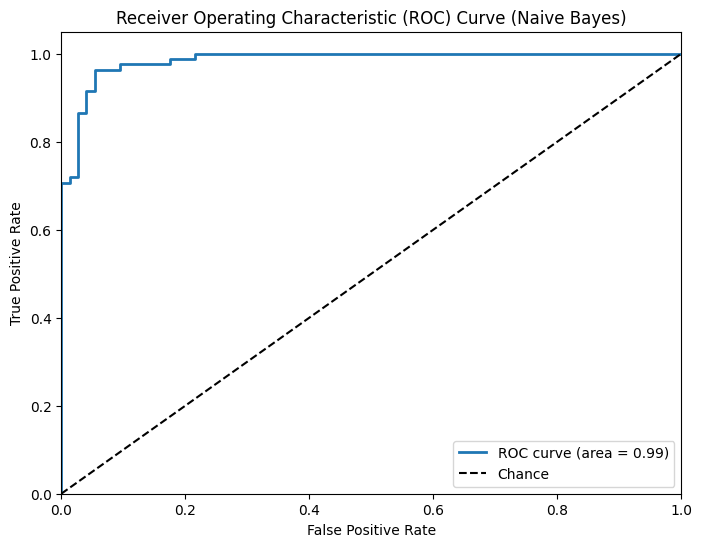

In [60]:
# Plot the ROC Curve
y_proba_nb = grid_search_nb.best_estimator_.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_proba_nb, pos_label=1)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f"ROC curve (area = {roc_auc_nb:0.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve (Naive Bayes)")
plt.legend(loc="lower right")
plt.show()


### Test the model with new reports in English

In [61]:
# Define the new reports
new_reports = [
    "A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.",
    "A miscommunication between air traffic control and the ground operations team led to a temporary taxiway hold, impacting the departure schedule of a domestic flight.",
    "A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.",
    "A passenger twisted their ankle when slipping on a wet floor near the boarding gate."
]

# Preprocess the new reports
preprocessed_reports = [preprocess_text(report) for report in new_reports]

# Transform the new reports using the trained vectorizer
new_reports_transformed = vectorizer.transform(preprocessed_reports)

# Predict the labels using the trained model
predicted_labels = grid_search_nb.predict(new_reports_transformed)

# Display the predictions
for report, label in zip(new_reports, predicted_labels):
    print(f"Report: {report}\nPredicted Label: {label}\n")

Report: A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.
Predicted Label: 0

Report: A miscommunication between air traffic control and the ground operations team led to a temporary taxiway hold, impacting the departure schedule of a domestic flight.
Predicted Label: 0

Report: A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.
Predicted Label: 1

Report: A passenger twisted their ankle when slipping on a wet floor near the boarding gate.
Predicted Label: 1



### Test the model with new reports in English and Dutch

In [62]:
# Define the new reports
new_reports_2 = [
    "A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.",
    "Een miscommunicatie tussen de luchtverkeersleiding en het grondoperatieteam leidde tot een tijdelijke taxibaanstop, met gevolgen voor het vertrekschema van een binnenlandse vlucht.",
    "A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.",
    "Een passagier verzwikte zijn enkel toen hij uitgleed over een natte vloer bij de instapgate.."
]

# Detect the language and translate new reports to English if needed
translated_reports = []
for report in new_reports_2:
    detected_lang = safe_detect_langid(report)
    translated_report = translate_to_english(report, detected_lang)
    translated_reports.append(translated_report)

# Preprocess the translated reports
preprocessed_reports = [preprocess_text(report) for report in translated_reports]

# Transform the preprocessed reports using the trained vectorizer
new_reports_transformed = vectorizer.transform(preprocessed_reports)

# Predict the labels using the trained model
predicted_labels = grid_search_nb.predict(new_reports_transformed)

# Display the predictions
for report, label in zip(new_reports_2, predicted_labels):
    print(f"Report: {report}\nPredicted Label: {label}\n")

Report: A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.
Predicted Label: 0

Report: Een miscommunicatie tussen de luchtverkeersleiding en het grondoperatieteam leidde tot een tijdelijke taxibaanstop, met gevolgen voor het vertrekschema van een binnenlandse vlucht.
Predicted Label: 0

Report: A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.
Predicted Label: 1

Report: Een passagier verzwikte zijn enkel toen hij uitgleed over een natte vloer bij de instapgate..
Predicted Label: 1



## Model 3: K-Nearest Neighbours (KNN)

### Split data into training and test set, vectorize

In [63]:

# Define X (text) and y (labels)
X = df['Processed_English']
y = df['label']

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize the vectorizer (using TF-IDF)
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), #consider both unigrams and bigrams (single words and pairs of consecutive words)
    analyzer="word", #feature should be made up of words
    preprocessor=None, #no custom pre-processing function is applied to the text before tokenization
    stop_words='english',  #remove common english stop words
    max_df=0.8, #ignore terms that are more in 80% of the documents
    min_df=5, #ignore terms that appear in fewer than 5 documnts
)

# Fit the vectorizer on the training data and transform both training and test data
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Print the shape of X_train and X_test
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (361, 177)
X_test shape: (156, 177)


### Build model

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance


In [65]:
# Set up KNN with Grid Search using F1 score for evaluation

# Initialize KNN and define a grid of hyperparameters
knn = KNeighborsClassifier()

# Define a grid of hyperparameters to search over
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11], # number of neighbors to consider
    'weights': ['uniform', 'distance'], # 'weights': 'uniform' gives equal weight to all neighbors, 'distance' weighs closer neighbors more heavily
    'metric': ['euclidean', 'manhattan', 'cosine'] #'euclidean' and 'manhattan' as standard measures,
#   and 'cosine' which can be more effective with high-dimensional TF-IDF vectors
}


# Set up grid search with 5-fold cross-validation using the weighted F1 score
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit grid search on the training data
grid_search_knn.fit(X_train, y_train)

# Print the best parameters and the best cross-validation score (F1)
print("Best Parameters (KNN):", grid_search_knn.best_params_)
print("Best Cross-Validation Score (F1) (KNN):", grid_search_knn.best_score_)

Best Parameters (KNN): {'metric': 'cosine', 'n_neighbors': 11, 'weights': 'distance'}
Best Cross-Validation Score (F1) (KNN): 0.9609591758452518


In [66]:
# Evaluate on the test set
y_pred_knn = grid_search_knn.predict(X_test)

In [67]:
# Calculate metrics
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn)

# Print evaluation results
print(f"The accuracy of the K-nearest neighbors model is {knn_accuracy:.4f}.")
print(f"The F1 score of the K-nearest neighbors model is {knn_f1:.4f}.")
print(f"The precision of the K-nearest neighborsn model is {knn_precision:.4f}.")
print(f"The recall of the K-nearest neighbors model is {knn_recall:.4f}.")

The accuracy of the K-nearest neighbors model is 0.9038.
The F1 score of the K-nearest neighbors model is 0.9123.
The precision of the K-nearest neighborsn model is 0.8764.
The recall of the K-nearest neighbors model is 0.9512.


In [68]:
# Print full classification report
print("Classification Report (KNN):\n", classification_report(y_test, y_pred_knn))

Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.94      0.85      0.89        74
           1       0.88      0.95      0.91        82

    accuracy                           0.90       156
   macro avg       0.91      0.90      0.90       156
weighted avg       0.91      0.90      0.90       156



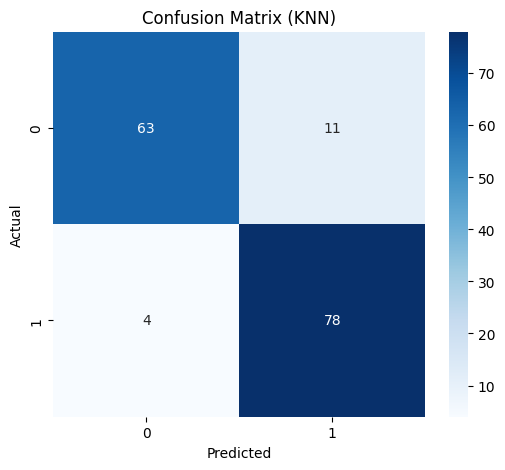

In [69]:
# Plot confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (KNN)")
plt.show()

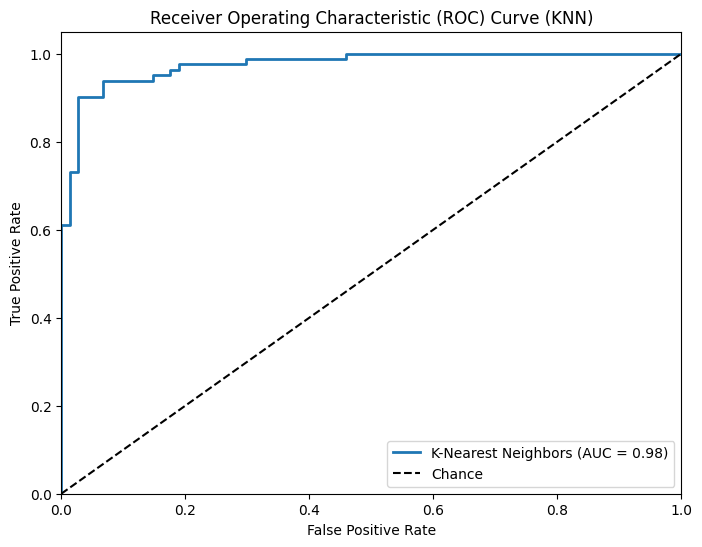

In [70]:
# Compute ROC curve and AUC for KNN
if hasattr(grid_search_knn.best_estimator_, "predict_proba"):
    y_proba_knn = grid_search_knn.best_estimator_.predict_proba(X_test)[:, 1]
else:
    y_proba_knn = grid_search_knn.best_estimator_.predict(X_test)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn, pos_label=1)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f"K-Nearest Neighbors (AUC = {roc_auc_knn:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve (KNN)")
plt.legend(loc="lower right")
plt.show()

In [71]:
# Convert the sparse X_test to a dense array for permutation_importance
X_test_dense = X_test.toarray()

# Use permutation importance on the dense array
result_knn = permutation_importance(
    grid_search_knn.best_estimator_, X_test_dense, y_test,
    scoring='f1_weighted', n_repeats=10, random_state=42
)


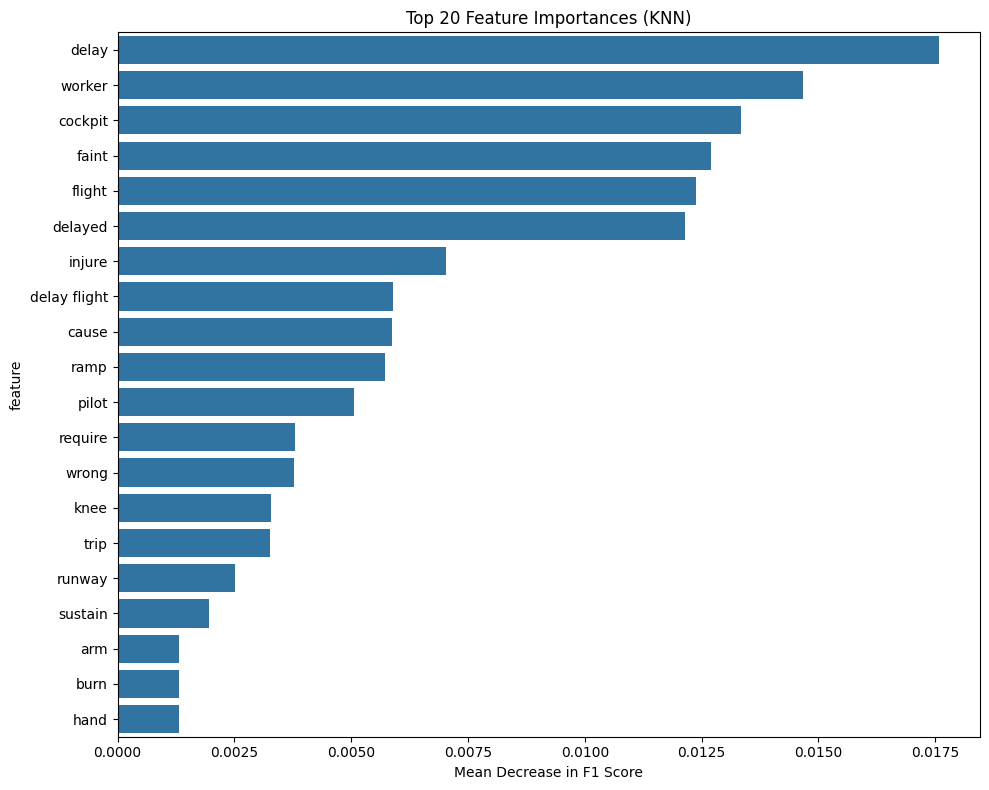

In [72]:
# Get names of features
feat_names = vectorizer.get_feature_names_out()
feature_importance_knn = pd.DataFrame({
    'feature': feat_names,
    'importance': result_knn.importances_mean
}).sort_values(by='importance', ascending=False)

# Plot the top 20 important features for KNN
top_features_knn = feature_importance_knn.head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_features_knn)
plt.xlabel("Mean Decrease in F1 Score")
plt.title("Top 20 Feature Importances (KNN)")
plt.tight_layout()
plt.show()

### Test the model with new reports in English

In [73]:
# Define the new reports
new_reports = [
    "A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.",
    "A miscommunication between air traffic control and the ground operations team led to a temporary taxiway hold, impacting the departure schedule of a domestic flight.",
    "A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.",
    "A passenger twisted their ankle when slipping on a wet floor near the boarding gate."
]

# Preprocess the new reports
preprocessed_reports = [preprocess_text(report) for report in new_reports]

# Transform the new reports using the trained vectorizer
new_reports_transformed = vectorizer.transform(preprocessed_reports)

# Predict the labels using the trained model
predicted_labels = grid_search_knn.predict(new_reports_transformed)

# Display the predictions
for report, label in zip(new_reports, predicted_labels):
    print(f"Report: {report}\nPredicted Label: {label}\n")

Report: A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.
Predicted Label: 0

Report: A miscommunication between air traffic control and the ground operations team led to a temporary taxiway hold, impacting the departure schedule of a domestic flight.
Predicted Label: 0

Report: A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.
Predicted Label: 1

Report: A passenger twisted their ankle when slipping on a wet floor near the boarding gate.
Predicted Label: 1



### Test the model with new reports in English and Dutch

In [74]:
# Define the new reports
new_reports_2 = [
    "A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.",
    "Een miscommunicatie tussen de luchtverkeersleiding en het grondoperatieteam leidde tot een tijdelijke taxibaanstop, met gevolgen voor het vertrekschema van een binnenlandse vlucht.",
    "A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.",
    "Een passagier verzwikte zijn enkel toen hij uitgleed over een natte vloer bij de instapgate.."
]

# Detect the language and translate new reports to English if needed
translated_reports = []
for report in new_reports_2:
    detected_lang = safe_detect_langid(report)
    translated_report = translate_to_english(report, detected_lang)
    translated_reports.append(translated_report)

# Preprocess the translated reports
preprocessed_reports = [preprocess_text(report) for report in translated_reports]

# Transform the preprocessed reports using the trained vectorizer
new_reports_transformed = vectorizer.transform(preprocessed_reports)

# Predict the labels using the trained model
predicted_labels = grid_search_knn.predict(new_reports_transformed)

# Display the predictions
for report, label in zip(new_reports_2, predicted_labels):
    print(f"Report: {report}\nPredicted Label: {label}\n")

Report: A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.
Predicted Label: 0

Report: Een miscommunicatie tussen de luchtverkeersleiding en het grondoperatieteam leidde tot een tijdelijke taxibaanstop, met gevolgen voor het vertrekschema van een binnenlandse vlucht.
Predicted Label: 0

Report: A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.
Predicted Label: 1

Report: Een passagier verzwikte zijn enkel toen hij uitgleed over een natte vloer bij de instapgate..
Predicted Label: 1



## Model 4: SVM

### Split data into training and test set, vectorize

In [75]:

# Define X (text) and y (labels)
X = df['Processed_English']
y = df['label']

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize the vectorizer (using TF-IDF)
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), #consider both unigrams and bigrams (single words and pairs of consecutive words)
    analyzer="word", #feature should be made up of words
    preprocessor=None, #no custom pre-processing function is applied to the text before tokenization
    stop_words='english',  #remove common english stop words
    max_df=0.8, #ignore terms that are more in 80% of the documents
    min_df=5, #ignore terms that appear in fewer than 5 documnts
)

# Fit the vectorizer on the training data and transform both training and test data
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Print the shape of X_train and X_test
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (361, 177)
X_test shape: (156, 177)


### Build model

In [76]:
from sklearn.svm import SVC

In [77]:
# Set up SVM with Grid Search

# Initialize SVM with a linear kernel (so that we can extract coefficients)
svm = SVC(kernel='linear', probability=True, max_iter=10000)

# Define a grid of hyperparameters to search over
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100]}

#Set up grid search with 5-fold cross-validation using the F1 weighted score
grid_search_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit grid search on the training data
grid_search_svm.fit(X_train, y_train)

# Print best parameters and best cross-validation score (F1)
print("Best Parameters (SVM):", grid_search_svm.best_params_)
print("Best Cross-Validation Score (F1) (SVM):", grid_search_svm.best_score_)

Best Parameters (SVM): {'C': 1}
Best Cross-Validation Score (F1) (SVM): 0.9509608636977058


In [78]:
# Evaluate on the test set

#Predict on the test set using the best found model
y_pred_svm = grid_search_svm.predict(X_test)

In [79]:
#Calculate metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)

# Print evaluation results
print(f"The accuracy of the SVM model is {svm_accuracy:.4f}.")
print(f"The F1 score of the SVM model is {svm_f1:.4f}.")
print(f"The precision of the SVM model is {svm_precision:.4f}.")
print(f"The recall of the SVM model is {svm_recall:.4f}.")

The accuracy of the SVM model is 0.9359.
The F1 score of the SVM model is 0.9419.
The precision of the SVM model is 0.9000.
The recall of the SVM model is 0.9878.


In [80]:
# Print the full classification report
print("Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))


Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.98      0.88      0.93        74
           1       0.90      0.99      0.94        82

    accuracy                           0.94       156
   macro avg       0.94      0.93      0.94       156
weighted avg       0.94      0.94      0.94       156



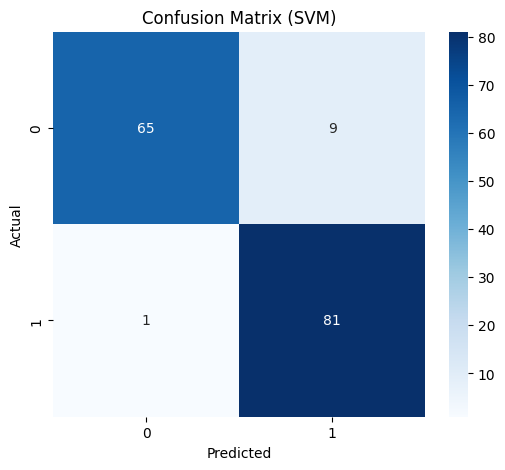

In [81]:
# Plot the confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SVM)")
plt.show()

In [82]:
# Confusion matrix as a table
cm_svm= confusion_matrix(y_test, y_pred_svm)
cm_table_svm = pd.DataFrame(cm_svm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix (Table Format) (SVM):")
print(cm_table_svm)

Confusion Matrix (Table Format) (SVM):
          Predicted 0  Predicted 1
Actual 0           65            9
Actual 1            1           81


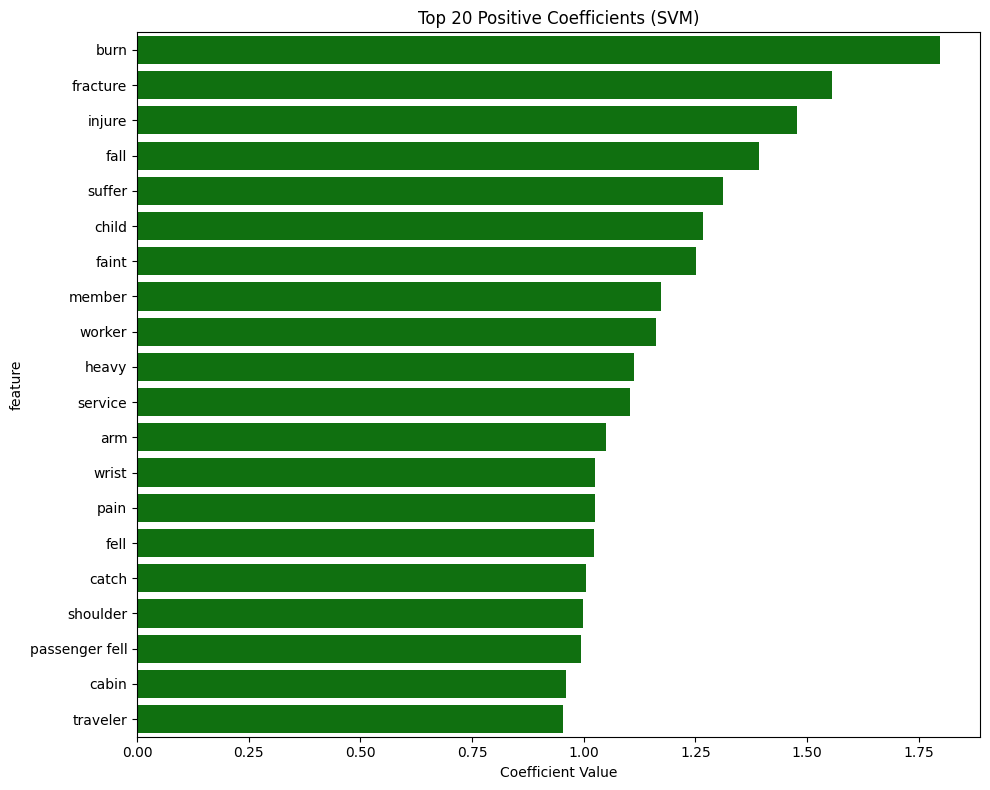

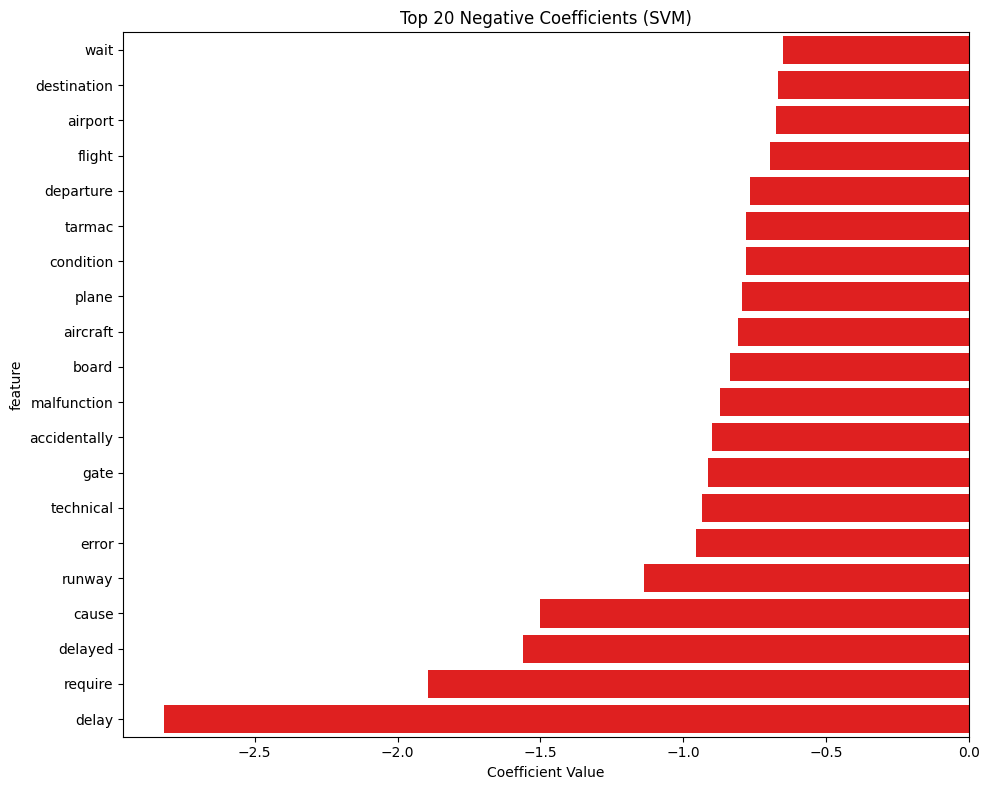

In [83]:
# For linear SVM, extract and visualize coefficients
coef_svm = grid_search_svm.best_estimator_.coef_.toarray()[0]
features_svm = vectorizer.get_feature_names_out()
coef_df_svm = pd.DataFrame({
    'feature': features_svm,
    'coefficient': coef_svm
}).sort_values(by='coefficient', ascending=False)

# Top 20 positive coefficients
top_positive_svm = coef_df_svm.head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x='coefficient', y='feature', data=top_positive_svm, color='green')
plt.xlabel("Coefficient Value")
plt.title("Top 20 Positive Coefficients (SVM)")
plt.tight_layout()
plt.show()

# Top 20 negative coefficients
top_negative_svm = coef_df_svm.tail(20)
plt.figure(figsize=(10, 8))
sns.barplot(x='coefficient', y='feature', data=top_negative_svm, color='red')
plt.xlabel("Coefficient Value")
plt.title("Top 20 Negative Coefficients (SVM)")
plt.tight_layout()
plt.show()

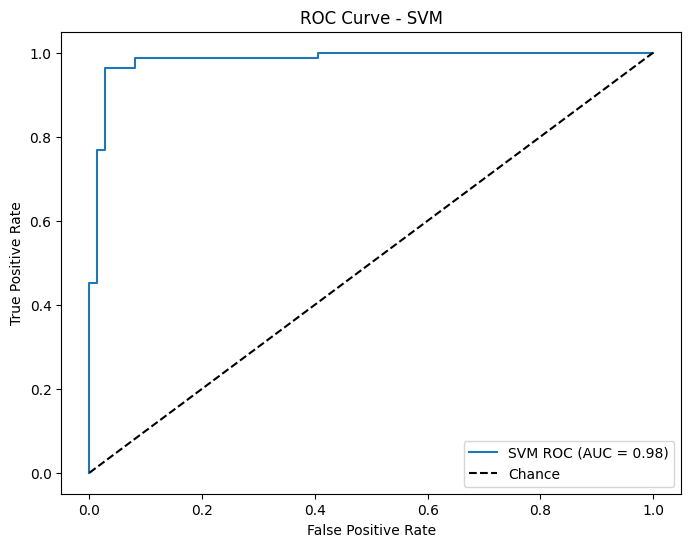

In [84]:
# Get the best SVM model (from grid_search_svm)
svm_model = grid_search_svm.best_estimator_

# Obtain probabilities or decision function scores
if hasattr(svm_model, "predict_proba"):
    y_proba_svm = svm_model.predict_proba(X_test)[:, 1]
else:
    y_proba_svm = svm_model.decision_function(X_test)

# Compute ROC curve and AUC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm, pos_label=1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM ROC (AUC = {roc_auc_svm:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.show()


### Test the model with new reports in English

In [85]:
# Define the new reports
new_reports = [
    "A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.",
    "A miscommunication between air traffic control and the ground operations team led to a temporary taxiway hold, impacting the departure schedule of a domestic flight.",
    "A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.",
    "A passenger twisted their ankle when slipping on a wet floor near the boarding gate."
]

# Preprocess the new reports
preprocessed_reports = [preprocess_text(report) for report in new_reports]

# Transform the new reports using the trained vectorizer
new_reports_transformed = vectorizer.transform(preprocessed_reports)

# Predict the labels using the trained model
predicted_labels = grid_search_svm.predict(new_reports_transformed)

# Display the predictions
for report, label in zip(new_reports, predicted_labels):
    print(f"Report: {report}\nPredicted Label: {label}\n")

Report: A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.
Predicted Label: 0

Report: A miscommunication between air traffic control and the ground operations team led to a temporary taxiway hold, impacting the departure schedule of a domestic flight.
Predicted Label: 0

Report: A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.
Predicted Label: 1

Report: A passenger twisted their ankle when slipping on a wet floor near the boarding gate.
Predicted Label: 0



### Test the model with new reports in English and Dutch

In [86]:
# Define the new reports
new_reports_2 = [
    "A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.",
    "Een miscommunicatie tussen de luchtverkeersleiding en het grondoperatieteam leidde tot een tijdelijke taxibaanstop, met gevolgen voor het vertrekschema van een binnenlandse vlucht.",
    "A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.",
    "Een passagier verzwikte zijn enkel toen hij uitgleed over een natte vloer bij de instapgate.."
]

# Detect the language and translate new reports to English if needed
translated_reports = []
for report in new_reports_2:
    detected_lang = safe_detect_langid(report)
    translated_report = translate_to_english(report, detected_lang)
    translated_reports.append(translated_report)

# Preprocess the translated reports
preprocessed_reports = [preprocess_text(report) for report in translated_reports]

# Transform the preprocessed reports using the trained vectorizer
new_reports_transformed = vectorizer.transform(preprocessed_reports)

# Predict the labels using the trained model
predicted_labels = grid_search_svm.predict(new_reports_transformed)

# Display the predictions
for report, label in zip(new_reports_2, predicted_labels):
    print(f"Report: {report}\nPredicted Label: {label}\n")

Report: A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.
Predicted Label: 0

Report: Een miscommunicatie tussen de luchtverkeersleiding en het grondoperatieteam leidde tot een tijdelijke taxibaanstop, met gevolgen voor het vertrekschema van een binnenlandse vlucht.
Predicted Label: 0

Report: A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.
Predicted Label: 1

Report: Een passagier verzwikte zijn enkel toen hij uitgleed over een natte vloer bij de instapgate..
Predicted Label: 1



## Model 5: Decision Tree

### Split data into training and test set, vectorize

In [87]:

# Define X (text) and y (labels)
X = df['Processed_English']
y = df['label']

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize the vectorizer (using TF-IDF)
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), #consider both unigrams and bigrams (single words and pairs of consecutive words)
    analyzer="word", #feature should be made up of words
    preprocessor=None, #no custom pre-processing function is applied to the text before tokenization
    stop_words='english',  #remove common english stop words
    max_df=0.8, #ignore terms that are more in 80% of the documents
    min_df=5, #ignore terms that appear in fewer than 5 documnts
)

# Fit the vectorizer on the training data and transform both training and test data
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Print the shape of X_train and X_test
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (361, 177)
X_test shape: (156, 177)


### Build model

In [88]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [89]:
# Set up Decision Tree with Grid search

# Initialize Decision Tree and set up grid search for hyperparameters
tree = DecisionTreeClassifier(random_state=42)

# Define a grid of hyperparameters to search over
param_grid_tree = {
    'criterion': ['gini', 'entropy'], # measure the quality of a split
    'max_depth': [None, 5, 10, 15, 20, 30], #Maximum depth of the tree
    'min_samples_split': [2, 5, 10], #Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4] #Minimum number of samples required to be at a leaf node
}


# Set up grid search with 5-fold cross-validation using the weighted F1 score
grid_search_tree = GridSearchCV(
    estimator=tree,
    param_grid=param_grid_tree,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit grid search on the training data
grid_search_tree.fit(X_train, y_train)

# Print best parameters and best cross-validation score (F1)
print("Best Parameters (Decision Tree):", grid_search_tree.best_params_)
print("Best Cross-Validation Score (F1) (Decision Tree):", grid_search_tree.best_score_)

Best Parameters (Decision Tree): {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Cross-Validation Score (F1) (Decision Tree): 0.8696323815011355


In [90]:
# Evaluate the best model on the test set

# Predict ib tge test set using the best found model
y_pred_tree = grid_search_tree.predict(X_test)

In [91]:
# Calculate metrics
tree_accuracy = accuracy_score(y_test, y_pred_tree)
tree_f1 = f1_score(y_test, y_pred_tree)
tree_precision = precision_score(y_test, y_pred_tree)
tree_recall = recall_score(y_test, y_pred_tree)

# Print evaluation results
print(f"The accuracy of the Decision Tree model is {tree_accuracy:.4f}.")
print(f"The F1 score of the Decision Tree model is {tree_f1:.4f}.")
print(f"The precision of the Decision Tree model is {tree_precision:.4f}.")
print(f"The recall of the Decision Tree model is {tree_recall:.4f}.")

The accuracy of the Decision Tree model is 0.8269.
The F1 score of the Decision Tree model is 0.8344.
The precision of the Decision Tree model is 0.8395.
The recall of the Decision Tree model is 0.8293.


In [92]:
# Print the full classification report
print("Classification Report (Decision Tree):\n", classification_report(y_test, y_pred_tree))


Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.81      0.82      0.82        74
           1       0.84      0.83      0.83        82

    accuracy                           0.83       156
   macro avg       0.83      0.83      0.83       156
weighted avg       0.83      0.83      0.83       156



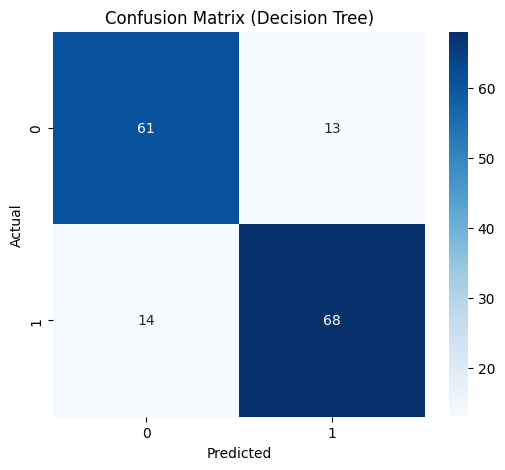

In [93]:
# Plot the confusion matrix
cm_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Decision Tree)")
plt.show()

In [94]:
# Confusiom Matrix as a table
cm_tree= confusion_matrix(y_test, y_pred_tree)
cm_table_tree = pd.DataFrame(cm_tree, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix (Table Format) (Decision Tree):")
print(cm_table_tree)

Confusion Matrix (Table Format) (Decision Tree):
          Predicted 0  Predicted 1
Actual 0           61           13
Actual 1           14           68


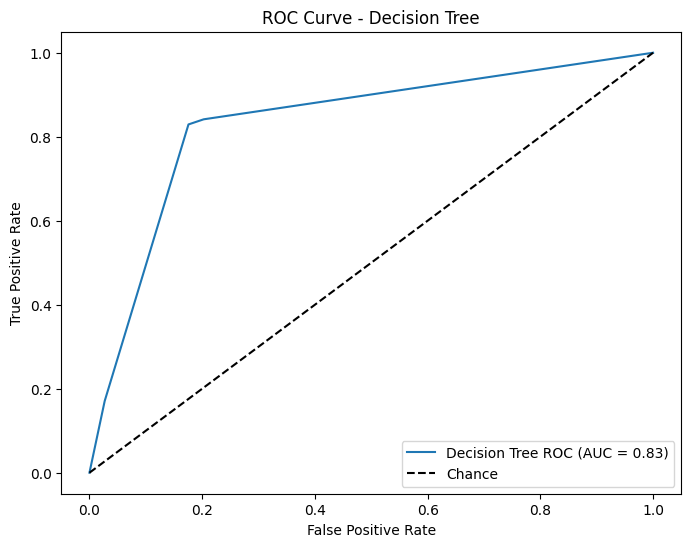

In [95]:
# ROC Curve for Decision Tree
tree_model = grid_search_tree.best_estimator_
if hasattr(tree_model, "predict_proba"):
    y_proba_tree = tree_model.predict_proba(X_test)[:, 1]
else:
    y_proba_tree = tree_model.decision_function(X_test)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree, pos_label=1)
roc_auc_tree = auc(fpr_tree, tpr_tree)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree ROC (AUC = {roc_auc_tree:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc="lower right")
plt.show()

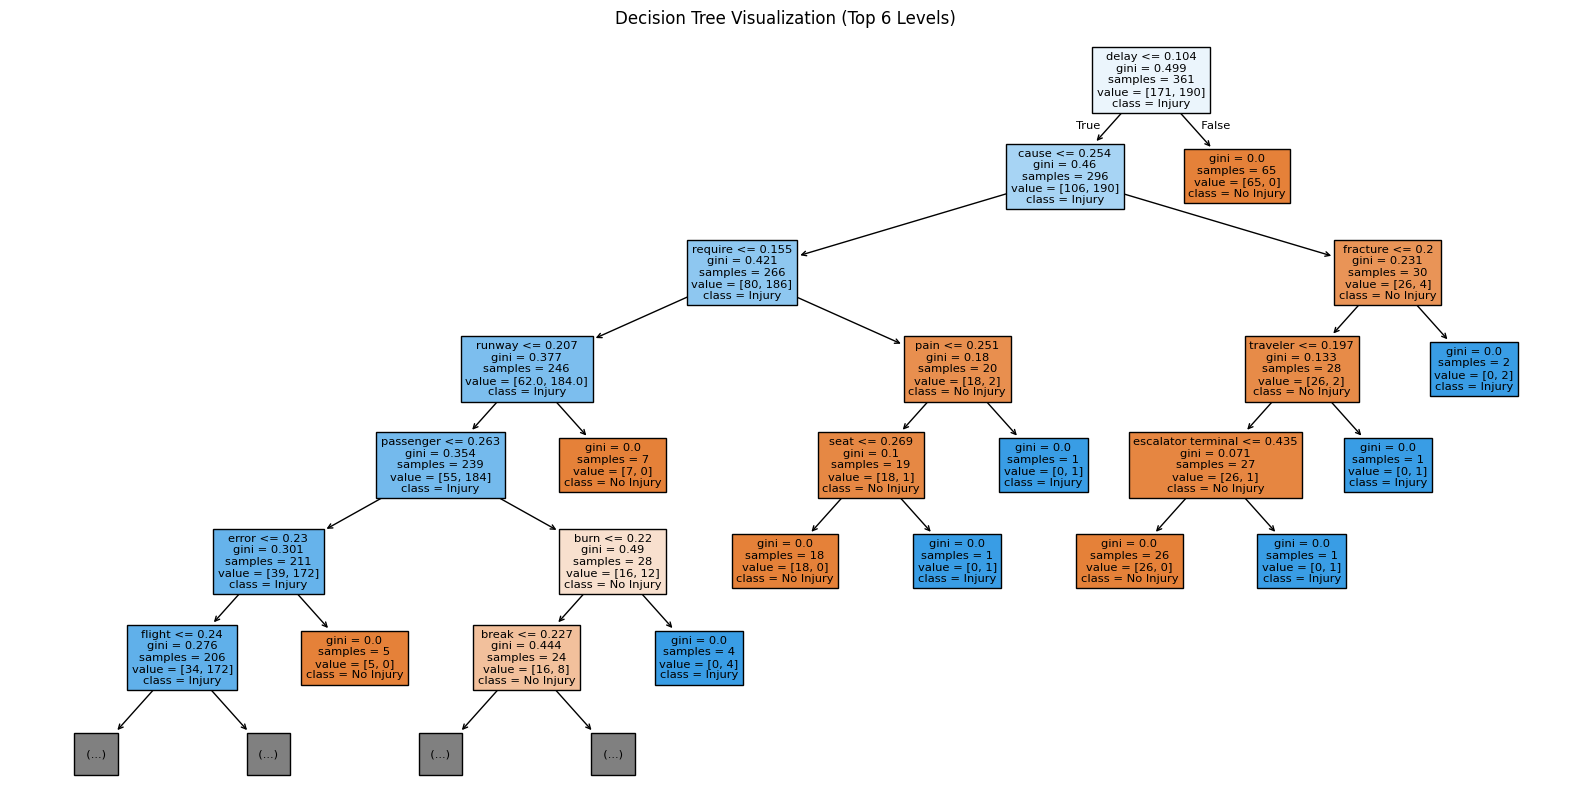

In [96]:
# Visualize the decision tree (showing only the top 6 levels for illustrative purposes)
plt.figure(figsize=(20, 10))
plot_tree(
    grid_search_tree.best_estimator_,
    feature_names=vectorizer.get_feature_names_out(),
    class_names=["No Injury", "Injury"],
    filled=True,
    max_depth=6
)
plt.title("Decision Tree Visualization (Top 6 Levels)")
plt.show()

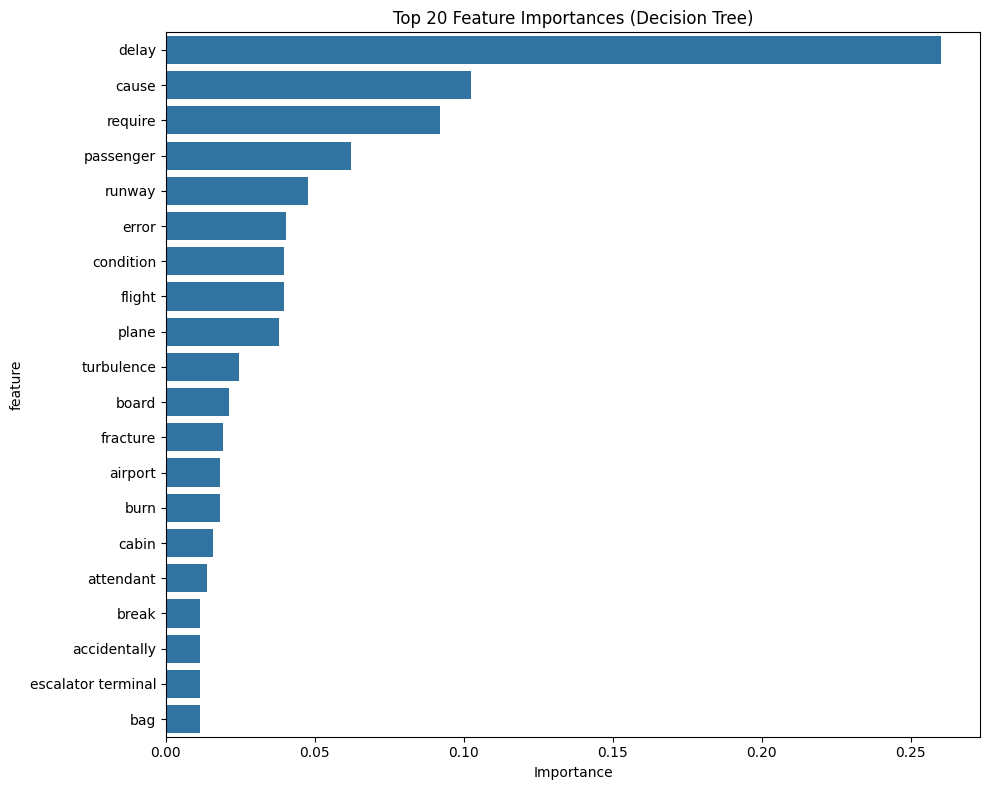

In [97]:
# Feature importances from the decision tree
importances_tree = grid_search_tree.best_estimator_.feature_importances_
feature_importances_tree = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': importances_tree
}).sort_values(by='importance', ascending=False)

top_features_tree = feature_importances_tree.head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_features_tree)
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()

### Test the model with new reports in English

In [98]:
# Define the new reports
new_reports = [
    "A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.",
    "A miscommunication between air traffic control and the ground operations team led to a temporary taxiway hold, impacting the departure schedule of a domestic flight.",
    "A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.",
    "A passenger twisted their ankle when slipping on a wet floor near the boarding gate."
]

# Preprocess the new reports
preprocessed_reports = [preprocess_text(report) for report in new_reports]

# Transform the new reports using the trained vectorizer
new_reports_transformed = vectorizer.transform(preprocessed_reports)

# Predict the labels using the trained model
predicted_labels = grid_search_tree.predict(new_reports_transformed)

# Display the predictions
for report, label in zip(new_reports, predicted_labels):
    print(f"Report: {report}\nPredicted Label: {label}\n")

Report: A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.
Predicted Label: 0

Report: A miscommunication between air traffic control and the ground operations team led to a temporary taxiway hold, impacting the departure schedule of a domestic flight.
Predicted Label: 1

Report: A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.
Predicted Label: 1

Report: A passenger twisted their ankle when slipping on a wet floor near the boarding gate.
Predicted Label: 1



### Test the model with new reports in English and Dutch

In [99]:
# Define the new reports
new_reports_2 = [
    "A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.",
    "Een miscommunicatie tussen de luchtverkeersleiding en het grondoperatieteam leidde tot een tijdelijke taxibaanstop, met gevolgen voor het vertrekschema van een binnenlandse vlucht.",
    "A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.",
    "Een passagier verzwikte zijn enkel toen hij uitgleed over een natte vloer bij de instapgate.."
]

# Detect the language and translate new reports to English if needed
translated_reports = []
for report in new_reports_2:
    detected_lang = safe_detect_langid(report)
    translated_report = translate_to_english(report, detected_lang)
    translated_reports.append(translated_report)

# Preprocess the translated reports
preprocessed_reports = [preprocess_text(report) for report in translated_reports]

# Transform the preprocessed reports using the trained vectorizer
new_reports_transformed = vectorizer.transform(preprocessed_reports)

# Predict the labels using the trained model
predicted_labels = grid_search_tree.predict(new_reports_transformed)

# Display the predictions
for report, label in zip(new_reports_2, predicted_labels):
    print(f"Report: {report}\nPredicted Label: {label}\n")

Report: A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.
Predicted Label: 0

Report: Een miscommunicatie tussen de luchtverkeersleiding en het grondoperatieteam leidde tot een tijdelijke taxibaanstop, met gevolgen voor het vertrekschema van een binnenlandse vlucht.
Predicted Label: 1

Report: A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.
Predicted Label: 1

Report: Een passagier verzwikte zijn enkel toen hij uitgleed over een natte vloer bij de instapgate..
Predicted Label: 1



## Model 6: Random Forest

### Split data into training and test set, vectorize

In [100]:

# Define X (text) and y (labels)
X = df['Processed_English']
y = df['label']

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize the vectorizer (using TF-IDF)
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), #consider both unigrams and bigrams (single words and pairs of consecutive words)
    analyzer="word", #feature should be made up of words
    preprocessor=None, #no custom pre-processing function is applied to the text before tokenization
    stop_words='english',  #remove common english stop words
    max_df=0.8, #ignore terms that are more in 80% of the documents
    min_df=5, #ignore terms that appear in fewer than 5 documnts
)

# Fit the vectorizer on the training data and transform both training and test data
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Print the shape of X_train and X_test
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (361, 177)
X_test shape: (156, 177)


### Build model

In [101]:
from sklearn.ensemble import RandomForestClassifier

In [102]:
# Set up Random Forest with Grid Search

# Initialize Random Forest and define a grid of hyperparameters
rf = RandomForestClassifier(random_state=42)

# Define a grid of hyperparameters to search over
param_grid_rf = {
    'n_estimators': [50, 100, 200], #Number of trees in the forest.
    'max_depth': [None, 10, 20, 30], #Maximum depth of each tree.
    'min_samples_split': [2, 5, 10], #Minimum number of samples required to split an internal node.
    'min_samples_leaf': [1, 2, 4], #Minimum number of samples required to be at a leaf node.
    'criterion': ['gini', 'entropy'] #Function to measure the quality of a split.
}

# Set up grid search with 5-fold validation cross-validation using the weighted F1 score
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit grid search on the training data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and best cross-validation score
print("Best Parameters (Random Forest):", grid_search_rf.best_params_)
print("Best Cross-Validation Score (F1) (Random Forest):", grid_search_rf.best_score_)

Best Parameters (Random Forest): {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Score (F1) (Random Forest): 0.9573030023260646


In [103]:
# Evaluate on the test set

# Predict on the test set using the best found model
y_pred_rf = grid_search_rf.predict(X_test)

In [104]:
# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)

# Print evaluation results
print(f"The accuracy of the Random Forest model is {rf_accuracy:.4f}.")
print(f"The F1 score of the Random Forest model is {rf_f1:.4f}.")
print(f"The precision of the Random Forest model is {rf_precision:.4f}.")
print(f"The recall of the Random Forest model is {rf_recall:.4f}.")


The accuracy of the Random Forest model is 0.9295.
The F1 score of the Random Forest model is 0.9333.
The precision of the Random Forest model is 0.9277.
The recall of the Random Forest model is 0.9390.


In [105]:
accuracy_rf= accuracy_score(y_test, y_pred_rf)
print(f"The accuracy of the Random Forest model is {accuracy_rf:.4f}.")

The accuracy of the Random Forest model is 0.9295.


In [106]:
# Print the full classification report
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.93      0.92      0.93        74
           1       0.93      0.94      0.93        82

    accuracy                           0.93       156
   macro avg       0.93      0.93      0.93       156
weighted avg       0.93      0.93      0.93       156



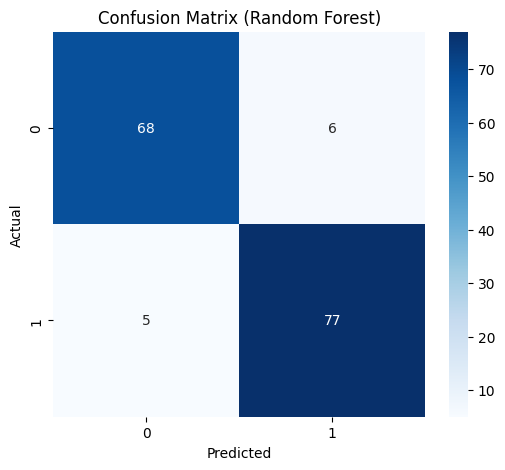

In [107]:
#Plot confusiom matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

In [108]:
# Confusion Matrix as a table
cm_rf= confusion_matrix(y_test, y_pred_rf)
cm_table_rf = pd.DataFrame(cm_rf, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix (Table Format) (Random Forest):")
print(cm_table_rf)

Confusion Matrix (Table Format) (Random Forest):
          Predicted 0  Predicted 1
Actual 0           68            6
Actual 1            5           77


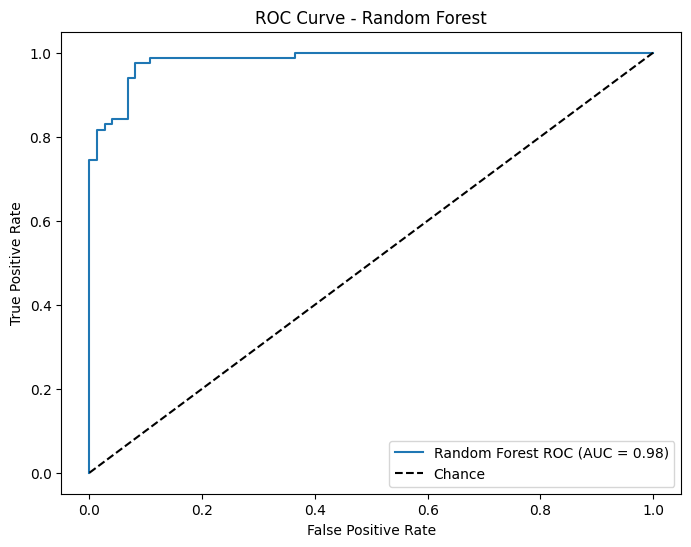

In [109]:
# ROC Curve for Random Forest
rf_model = grid_search_rf.best_estimator_
if hasattr(rf_model, "predict_proba"):
    y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
else:
    y_proba_rf = rf_model.decision_function(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf, pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest ROC (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()

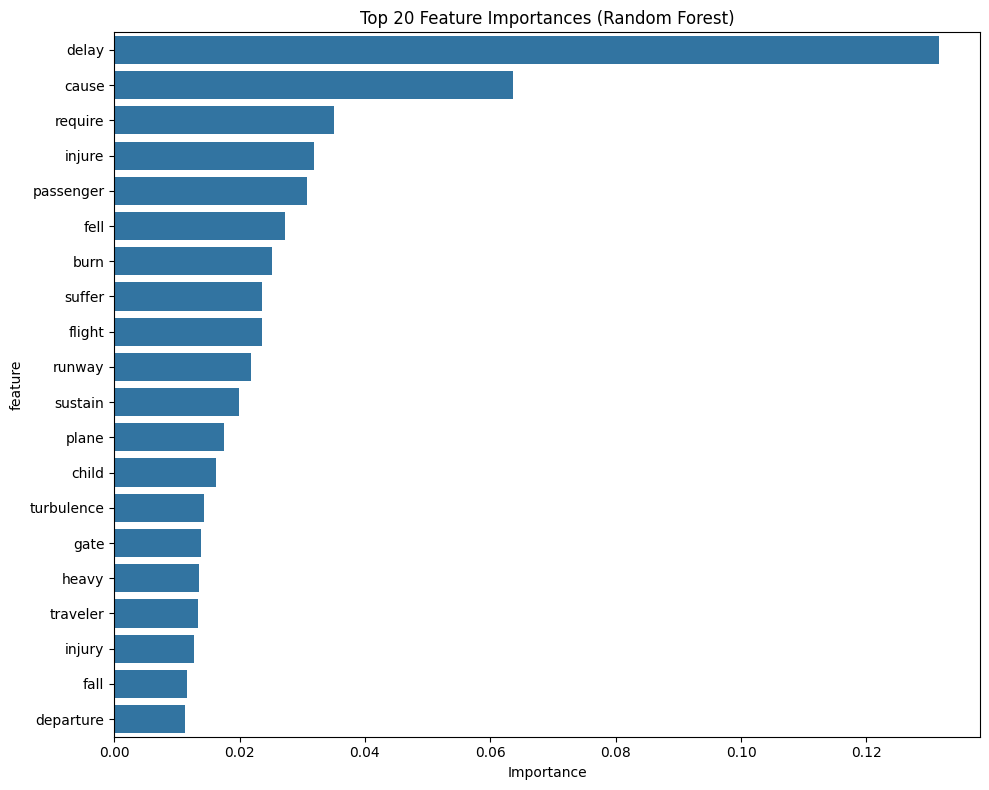

In [110]:
# Feature importances from Random Forest
importances_rf = grid_search_rf.best_estimator_.feature_importances_
feature_importances_rf = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': importances_rf
}).sort_values(by='importance', ascending=False)

top_features_rf = feature_importances_rf.head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_features_rf)
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


### Test the model with new reports in English

In [111]:
# Define the new reports
new_reports = [
    "A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.",
    "A miscommunication between air traffic control and the ground operations team led to a temporary taxiway hold, impacting the departure schedule of a domestic flight.",
    "A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.",
    "A passenger twisted their ankle when slipping on a wet floor near the boarding gate."
]

# Preprocess the new reports
preprocessed_reports = [preprocess_text(report) for report in new_reports]

# Transform the new reports using the trained vectorizer
new_reports_transformed = vectorizer.transform(preprocessed_reports)

# Predict the labels using the trained model
predicted_labels = grid_search_rf.predict(new_reports_transformed)

# Display the predictions
for report, label in zip(new_reports, predicted_labels):
    print(f"Report: {report}\nPredicted Label: {label}\n")

Report: A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.
Predicted Label: 0

Report: A miscommunication between air traffic control and the ground operations team led to a temporary taxiway hold, impacting the departure schedule of a domestic flight.
Predicted Label: 0

Report: A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.
Predicted Label: 1

Report: A passenger twisted their ankle when slipping on a wet floor near the boarding gate.
Predicted Label: 1



### Test the model with new reports in English and Dutch

In [112]:
# Define the new reports
new_reports_2 = [
    "A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.",
    "Een miscommunicatie tussen de luchtverkeersleiding en het grondoperatieteam leidde tot een tijdelijke taxibaanstop, met gevolgen voor het vertrekschema van een binnenlandse vlucht.",
    "A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.",
    "Een passagier verzwikte zijn enkel toen hij uitgleed over een natte vloer bij de instapgate.."
]

# Detect the language and translate new reports to English if needed
translated_reports = []
for report in new_reports_2:
    detected_lang = safe_detect_langid(report)
    translated_report = translate_to_english(report, detected_lang)
    translated_reports.append(translated_report)

# Preprocess the translated reports
preprocessed_reports = [preprocess_text(report) for report in translated_reports]

# Transform the preprocessed reports using the trained vectorizer
new_reports_transformed = vectorizer.transform(preprocessed_reports)

# Predict the labels using the trained model
predicted_labels = grid_search_rf.predict(new_reports_transformed)

# Display the predictions
for report, label in zip(new_reports_2, predicted_labels):
    print(f"Report: {report}\nPredicted Label: {label}\n")

Report: A technical malfunction in the self-check-in kiosks created a queue at the terminal, delaying the boarding process for an international flight.
Predicted Label: 0

Report: Een miscommunicatie tussen de luchtverkeersleiding en het grondoperatieteam leidde tot een tijdelijke taxibaanstop, met gevolgen voor het vertrekschema van een binnenlandse vlucht.
Predicted Label: 0

Report: A ramp service technician sustained a sprained wrist after tripping over equipment while repositioning heavy cargo near the tarmac.
Predicted Label: 1

Report: Een passagier verzwikte zijn enkel toen hij uitgleed over een natte vloer bij de instapgate..
Predicted Label: 1



## Model Comparisson

In [113]:
# Compile model performance into a DataFrame
model_performance = pd.DataFrame({
    "Model": ["Logistic Regression", "Naive Bayes", "K-Nearest Neighbors", "SVM", "Decision Tree", "Random Forest"],
    "Accuracy": [logreg_accuracy, nb_accuracy, knn_accuracy, svm_accuracy, tree_accuracy, rf_accuracy],
    "F1 Score": [logreg_f1, nb_f1, knn_f1, svm_f1, tree_f1, rf_f1],
    "Precision": [logreg_precision, nb_precision, knn_precision, svm_precision, tree_precision, rf_precision],
    "Recall": [logreg_recall, nb_recall, knn_recall, svm_recall, tree_recall, rf_recall]
})



In [114]:
model_performance

,Model,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.942308,0.947368,0.910112,0.987805
1,Naive Bayes,0.935897,0.940476,0.918605,0.963415
2,K-Nearest Neighbors,0.903846,0.912281,0.876404,0.951220
3,SVM,0.935897,0.941860,0.900000,0.987805
4,Decision Tree,0.826923,0.834356,0.839506,0.829268
5,Random Forest,0.929487,0.933333,0.927711,0.939024


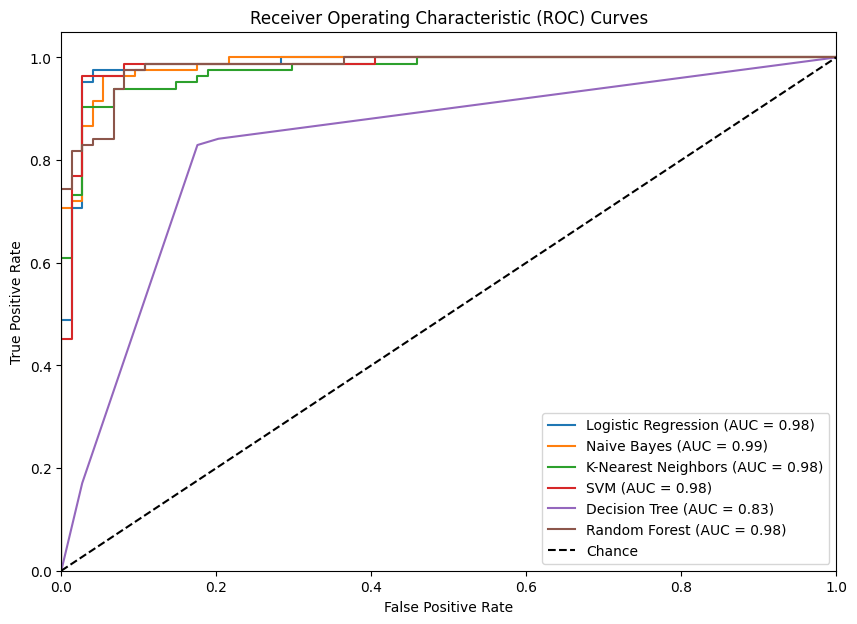

In [115]:
# Plot all ROC curves in one chart
plt.figure(figsize=(10, 7))

plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {roc_auc_nb:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"K-Nearest Neighbors (AUC = {roc_auc_knn:.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.2f})")
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {roc_auc_tree:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.show()

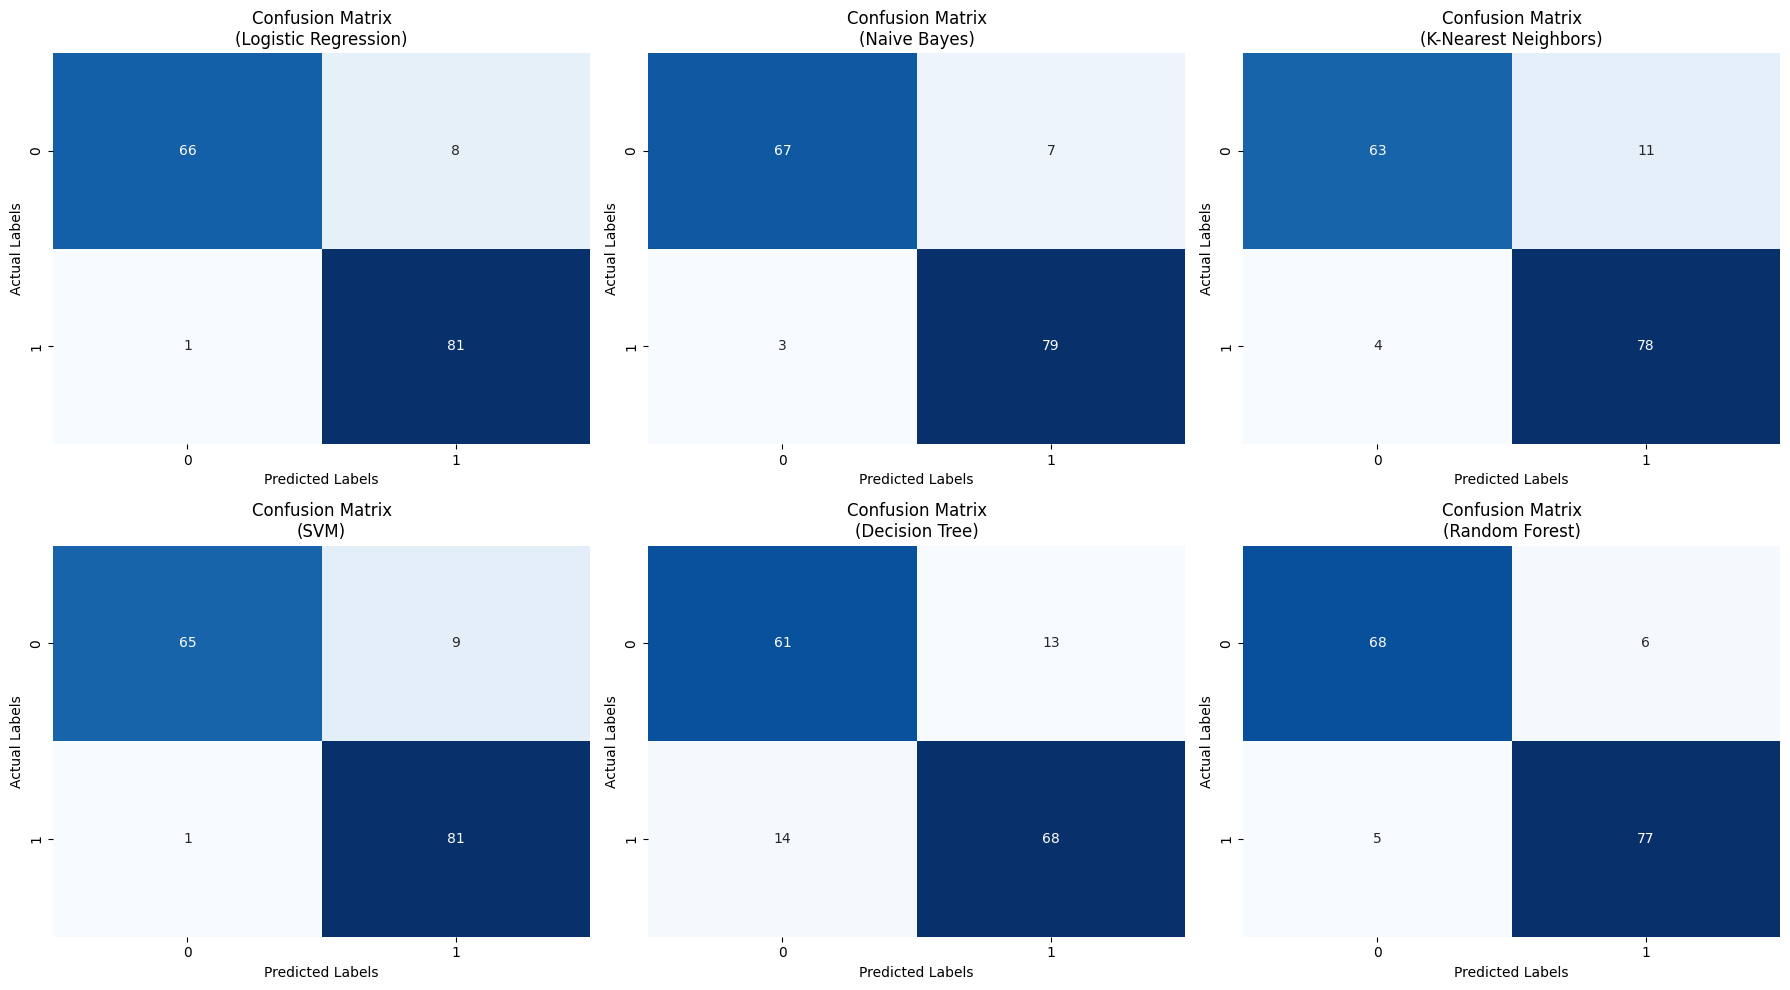

In [116]:
# List of confusion matrices and corresponding model names
conf_matrices = [
    (confusion_matrix(y_test, y_pred_lg), "Logistic Regression"),
    (confusion_matrix(y_test, y_pred_nb), "Naive Bayes"),
    (confusion_matrix(y_test, y_pred_knn), "K-Nearest Neighbors"),
    (confusion_matrix(y_test, y_pred_svm), "SVM"),
    (confusion_matrix(y_test, y_pred_tree), "Decision Tree"),
    (confusion_matrix(y_test, y_pred_rf), "Random Forest")
]

# Plotting the confusion matrices in a grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, (cm, model_name) in zip(axes.flatten(), conf_matrices):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f"Confusion Matrix\n({model_name})")
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('Actual Labels')

plt.tight_layout()
plt.show()